In [95]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.rijke_esn import RijkeESN
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils.enums import eParam, get_eVar
from pathlib import Path
from adjoint_esn.utils import signals as sig
import adjoint_esn.utils.visualizations as vis
from adjoint_esn.utils import errors
from scipy import signal
from functools import partial
import yaml
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils.discretizations import finite_differences
import adjoint_esn.utils.solve_ode as solve_ode
from adjoint_esn.rijke_galerkin.solver import Rijke
from adjoint_esn.rijke_galerkin import sensitivity as sens

In [59]:
def load_config(experiment_path):
       with open(experiment_path/'config.yml', 'r') as file:
         config = yaml.unsafe_load(file)
         return config

experiment_path=Path('../local_results/rijke/run_20231029_153121') # no noise
# experiment_path=Path("../final_results/standard/run_20231031_152932")  # standard with [eta,mu]
# experiment_path=Path("../final_results/standard/run_20231031_152907")  # standard with [eta,mu,v]

# experiment_path=Path('../local_results/rijke/run_20240307_175258')

config = load_config(experiment_path)
results = pp.unpickle_file(experiment_path / 'results.pickle')[0]
print(config)
print(results)

model:
  connectivity: 20
  input_only_mode: false
  input_vars: eta_mu_v_tau
  input_weights_mode: sparse_grouped_rijke
  network_dt: 0.01
  output_vars: eta_mu
  param_vars:
  - beta
  r2_mode: false
  reservoir_size: 1200
  reservoir_weights_mode: erdos_renyi1
  type: rijke
  u_f_order: 1
  washout_time: 4
random_seed: 41
simulation:
  N_g: 4
  beta_list:
  - 1.0
  - 2.0
  - 3.0
  - 4.0
  - 5.0
  noise_level: 0
  sim_dt: 0.001
  sim_time: 800
  tau_list:
  - 0.1
  - 0.15
  - 0.2
  - 0.25
  - 0.3
  transient_time: 200
train:
  regime_selection: 20
  tikhonov: 0.001
  time: 8
val:
  error_measure: rel_L2
  fold_time: 4
  hyperparameters:
    input_scaling:
      max: 5.0
      min: 0.01
      scale: log10
    leak_factor:
      max: 1.0
      min: 0.01
      scale: log10
    parameter_normalization_mean:
      beta:
        max: 10.0
        min: -10.0
        scale: uniform
    parameter_normalization_var:
      beta:
        max: 10.0
        min: 0.01
        scale: log10
    spect

In [10]:
val_random_seeds = results["validation_random_seeds"]

In [6]:
results["training_random_seeds"]

array([1646, 1660, 1655, 1651, 1648, 1649, 1658, 1652, 1656, 1650, 1659,
       1645, 1665, 1647, 1662, 1661, 1664, 1663, 1654, 1642])

In [4]:
results_new = {}
for key in results.keys():
    if key != "f":
        results_new[key] = results[key]

In [5]:
results_new["tikhonov"] = 1e-6*np.ones(len(results_new["tikhonov"]))

In [58]:
results_new["training_random_seeds"] = results["training_random_seeds"] + 100 * 16
results_new["validation_random_seeds"] = results["validation_random_seeds"] + 100 * 16

In [7]:
pp.pickle_file(experiment_path/'results.pickle',results_new)

## Data generation

In [60]:
integrator = 'odeint'

# number of galerkin modes
N_g = config.simulation.N_g

# simulation options
sim_dt = config.simulation.sim_dt

# directory to search for simulation data, if the data doesn't exist, 
# then it will simulate the system
data_dir=Path('..\data')

# which regimes to use for training and validation
train_param_list = results["training_parameters"]
val_param_list = results["validation_parameters"]
# add_param_list = np.array([[6.0, 0.2],
#                            [7.0, 0.2],
#                            [8.0, 0.2],
#                            [9.0, 0.2]])

# train_param_list = np.vstack((train_param_list, add_param_list))      
#        
# Create the mesh to get the data from
# param_mesh_input = [None] * 2
# param_mesh_input[eParam.beta] = [2.0]
# param_mesh_input[eParam.tau] = [0.2]
# train_param_list= pp.make_param_mesh(param_mesh_input)   

train_idx_list = np.arange(len(train_param_list))

transient_time = config.simulation.transient_time

noise_level = config.simulation.noise_level
noise_std = 0.0
random_seed = config.random_seed

# network time step
network_dt = config.model.network_dt

washout_time = config.model.washout_time

# which states to use as input and output
# for standard ESN these should be the same, e.g. both 'eta_mu'
# for Rijke ESN, input and output should be 'eta_mu_v_tau' and 'eta_mu' respectively
input_vars = config.model.input_vars
eInputVar = get_eVar(input_vars,N_g)
output_vars = config.model.output_vars
eOutputVar = get_eVar(output_vars,N_g)

# which system parameter is passed to the ESN
param_vars=config.model.param_vars

# if using Rijke ESN what is the order of u_f(t-tau) in the inputs,
# [u_f(t-tau), u_f(t-tau)^2 ..., u_f(t-tau)^(u_f_order)]
u_f_order = config.model.u_f_order

# length of training time series
train_time = config.train.time
val_time = config.val.time

loop_names=['train','val']
loop_times = [train_time,val_time]
sim_time = config.simulation.sim_time #transient_time + 2*washout_time + train_time + val_time

DATA = {}
for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}


full_list = np.vstack([train_param_list,val_param_list])
for p_idx, p in enumerate(train_param_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir,integrator=integrator)
    if "training_random_seeds" in results.keys():
        noise_seed = results["training_random_seeds"][p_idx]
    else:
        noise_seed = random_seed
    regime_data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        loop_names=loop_names,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        noise_level=noise_level,
                        noise_std=noise_std,
                        random_seed=noise_seed,
                        tau=p_sim["tau"],
                        )
    
    for loop_name in loop_names:
        [DATA[loop_name][var].append(regime_data[loop_name][var]) for var in DATA[loop_name].keys()]

# dimension of the inputs
dim = DATA["train"]["u"][0].shape[1]

# DATA_clean = {}
# for loop_name in loop_names:
#     DATA_clean[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

# for p_idx, p in enumerate(train_param_list):
#     p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
#     y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
#                                 sim_time=sim_time,sim_dt=sim_dt,
#                                 data_dir=data_dir,integrator=integrator)

#     regime_data = pp.create_dataset(y_sim,t_sim,p_sim,
#                         network_dt=network_dt,
#                         transient_time=transient_time,
#                         washout_time=washout_time,
#                         loop_times=loop_times,
#                         loop_names=loop_names,
#                         input_vars=input_vars,
#                         output_vars=output_vars,
#                         param_vars=param_vars,
#                         N_g=N_g,
#                         u_f_order=u_f_order,
#                         noise_level=0.0,
#                         noise_std=0.0,
#                         random_seed=results["training_random_seeds"][p_idx],
#                         tau=p_sim["tau"])
    
#     for loop_name in loop_names:
#         [DATA_clean[loop_name][var].append(regime_data[loop_name][var]) for var in DATA_clean[loop_name].keys()]

In [ ]:
from scipy import signal
train_idx = 14
u_idx = 7
t = DATA["train"]["t"][train_idx]
uu = DATA["train"]["u"][train_idx][:,u_idx]
uu_clean = DATA_clean["train"]["u"][train_idx][:,u_idx]
T = sig.period(uu, network_dt)
print('Period of the signal:', T)
T_steps = pp.get_steps(T, network_dt)
max_n_T = int(np.floor(len(uu)/T_steps))
omega_T = 2*np.pi / T
uu = uu[:max_n_T*T_steps]
uu_clean = uu_clean[:max_n_T*T_steps]
t = t[:max_n_T*T_steps]

_, asd = sig.amplitude_spectrum(uu, network_dt)
_, asd_clean = sig.amplitude_spectrum(uu_clean, network_dt)

# 3rd order butterworth low-pass filter
b, a = signal.butter(3, 10 * 1/T, fs = 1/network_dt)
uu_f_low = signal.filtfilt(b, a, uu)
_, asd_low = sig.amplitude_spectrum(uu_f_low, network_dt)

# filter out frequencies other than the periodic peaks
# Get the signal length and number of signals
## add if even if odd
signal_length = len(uu)
# Determine the fourier frequencies
omega = 1 / network_dt * 2 * np.pi * np.fft.fftfreq(signal_length)
# Take the fourier transform of the signal
X_fft = np.fft.fft(uu)
first_peak_idx = np.where(np.isclose(omega,omega_T))[0]
max_peak = 10
peak_idxs = np.arange(1,max_peak) * first_peak_idx
X_fft_new = np.zeros_like(X_fft)
X_fft_new[0] = X_fft[0]
X_fft_new[peak_idxs] = X_fft[peak_idxs]
X_fft_new[-peak_idxs] = X_fft[-peak_idxs]
uu_f_peak = np.real(np.fft.ifft(X_fft_new))
_, asd_peak = sig.amplitude_spectrum(uu_f_peak, network_dt)

# savitzky-golay filter
window_length = 50
polyorder = 4
uu_f_sg = signal.savgol_filter(uu, window_length, polyorder)
omega, asd_sg = sig.amplitude_spectrum(uu_f_sg, network_dt)

plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
plt.plot(t, uu, 'silver', linewidth=2.0)
plt.plot(t, uu_clean, 'r', linewidth=2.0)
plt.plot(t, uu_f_low, 'k--')
plt.grid(True)
plt.title('Low-pass')

plt.subplot(2,3,4)
plt.plot(omega, asd, 'silver', linewidth=6.0)
plt.plot(omega, asd_clean, 'r', linewidth=2.0)
plt.plot(omega, asd_low, 'k--')
plt.legend(('noisy','clean','filtered'))
plt.grid(True)
plt.xscale('log')

plt.subplot(2,3,2)
plt.plot(t, uu, 'silver', linewidth=2.0)
plt.plot(t, uu_clean, 'r', linewidth=2.0)
plt.plot(t, uu_f_peak, 'k--')
plt.grid(True)
plt.title('Periodic')

plt.subplot(2,3,5)
plt.plot(omega, asd, 'silver', linewidth=6.0)
plt.plot(omega, asd_clean, 'r', linewidth=2.0)
plt.plot(omega, asd_peak, 'k--')
plt.legend(('noisy','clean','filtered'))
plt.grid(True)
plt.xscale('log')

plt.subplot(2,3,3)
plt.plot(t, uu, 'silver', linewidth=2.0)
plt.plot(t, uu_clean, 'r', linewidth=2.0)
plt.plot(t, uu_f_sg, 'k--')
plt.grid(True)
plt.title('Savgol')

plt.subplot(2,3,6)
plt.plot(omega, asd, 'silver', linewidth=6.0)
plt.plot(omega, asd_clean, 'r', linewidth=2.0)
plt.plot(omega, asd_sg, 'k--')
plt.legend(('noisy','clean','filtered'))
plt.grid(True)
plt.xscale('log')
plt.show()

### Plot data

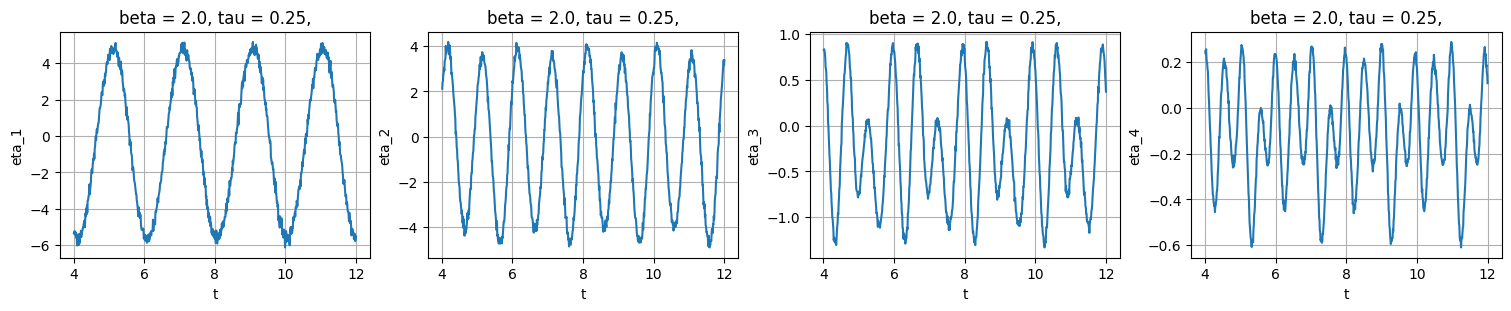

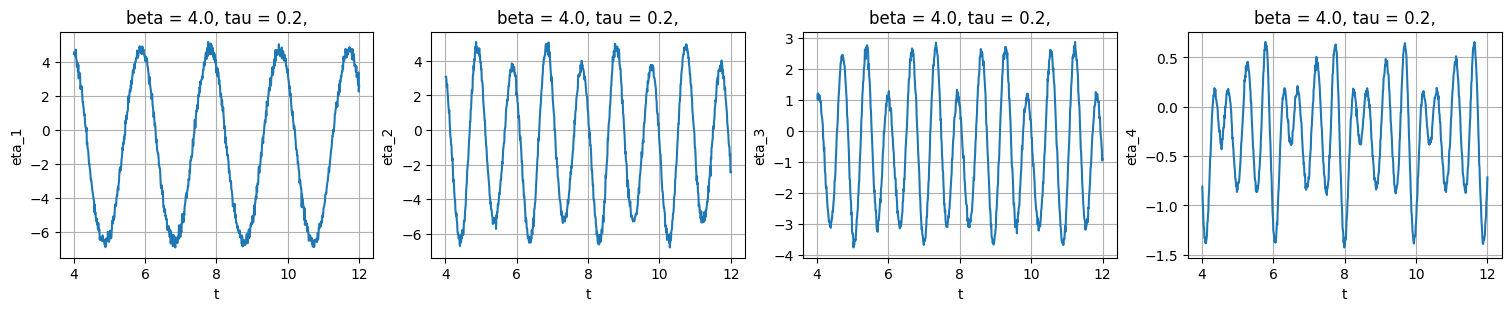

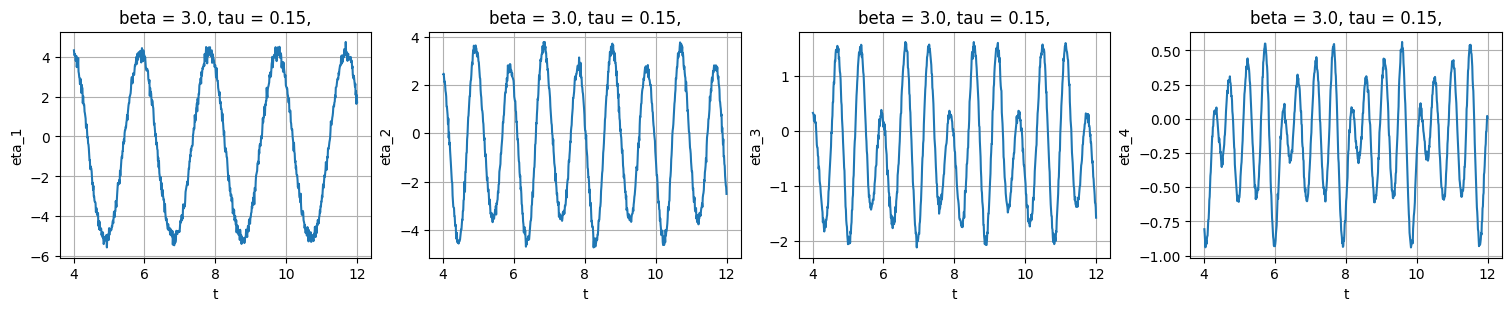

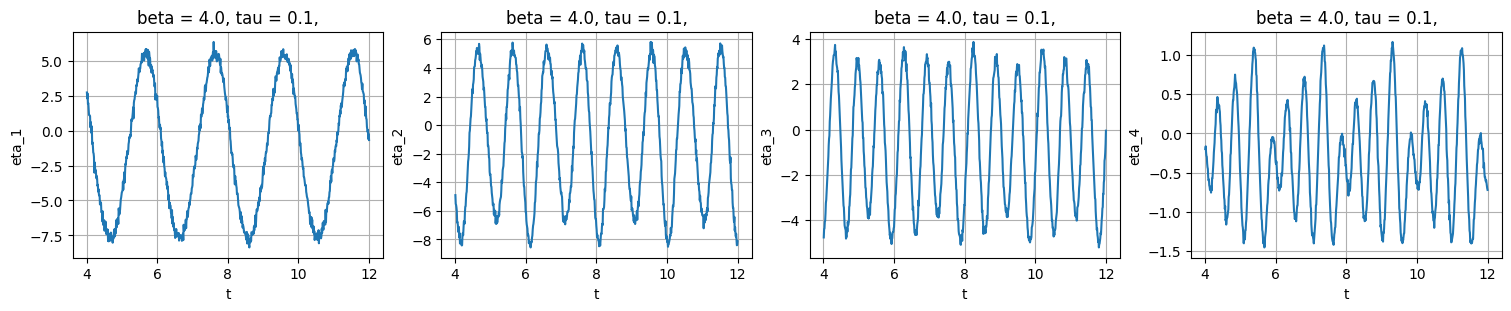

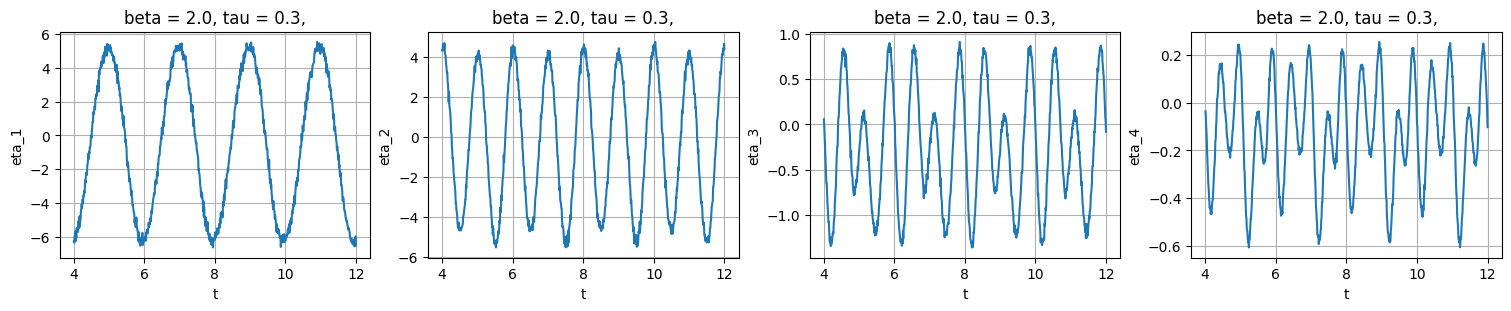

In [ ]:
len_p_list=len(train_param_list)
plt_idx = [eInputVar.eta_1,eInputVar.eta_2,eInputVar.eta_3,eInputVar.eta_4]
for p_idx in np.arange(5,10):
    plt.figure(figsize = (15,3),constrained_layout=True)
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        vis.plot_lines(DATA["train"]["t"][p_idx],
                       DATA["train"]["u"][p_idx][:,k],
                       #DATA_f["train"]["u"][p_idx][:,k],
                       #DATA_clean["train"]["u"][p_idx][:,k],
                       title=f"beta = {train_param_list[p_idx][eParam.beta]}, tau = {train_param_list[p_idx][eParam.tau]},",
                       xlabel='t',
                       ylabel=k.name,
                       linestyle=['-','-','--'])

        # plt.xlim([washout_time,20+washout_time])

## Train ESN

In [61]:
def create_ESN(ESN_dict, model_type, hyp_param_names, hyp_param_scales, hyp_params):
    if model_type == 'standard':
        my_ESN = ESN(**ESN_dict)
    elif model_type == 'rijke':
        my_ESN = RijkeESN(**ESN_dict)
    set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)
    return my_ESN

In [62]:
ESN_dict = {
        "reservoir_size": config.model.reservoir_size,
        "parameter_dimension": len(param_vars),
        "reservoir_connectivity": config.model.connectivity,
        "r2_mode": config.model.r2_mode,
        "input_only_mode": config.model.input_only_mode,
        "input_weights_mode": config.model.input_weights_mode,
        "reservoir_weights_mode": config.model.reservoir_weights_mode,
        "tikhonov": config.train.tikhonov,
        # "output_bias": np.array([1.0])
    }
if config.model.type == "standard":
    ESN_dict["dimension"] = dim
elif config.model.type == "rijke":
    ESN_dict["N_g"] = config.simulation.N_g
    ESN_dict["x_f"] = 0.2
    ESN_dict["dt"] = config.model.network_dt
    ESN_dict["u_f_order"] = config.model.u_f_order

print('System dimension: ', dim)

top_idx = 0
hyp_param_names = []
hyp_params = []
for name in results.keys():
    if name not in ['training_parameters','validation_parameters','f','tikh']:
        if results[name].ndim == 2:
            hyp_param_names.extend([name]*results[name].shape[1])
            hyp_params.extend(results[name][top_idx])
        elif results[name].ndim == 1:
            hyp_param_names.extend([name])
            hyp_params.extend([results[name][top_idx]])
        
hyp_param_scales = ['uniform']*len(hyp_param_names)
# expand the ESN dict with the fixed seeds
ESN_dict["input_seeds"] = [0,1,2]
ESN_dict["reservoir_seeds"] = [3,4]
# ESN_dict["output_bias"] = np.array([1.0])
my_ESN = create_ESN(ESN_dict, config.model.type, hyp_param_names, hyp_param_scales, hyp_params)
# my_ESN.leak_factor = 1.0
my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)

System dimension:  9
Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Input weights of u_f(t-tau) are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.
Parameter normalization is changed, training must be done again.
Reservoir weights are rescaled with the new spectral radius.
Parameter normalization is changed, training must be done again.
Input weights are rescaled with the new input scaling.
Input weights of u_f(t-tau) are rescaled with the new input scaling.


In [ ]:
my_ESN.W_out

array([[ 24.6436613 ,   1.94264589, -23.63017504, ..., -23.39008453,
         16.16829815,   3.30415951],
       [ 31.70601373, -60.47031326, -24.16507811, ..., -97.684005  ,
        -25.8006168 , -26.14822174],
       [-23.47705517, -42.25515813, -45.4249132 , ..., -64.71840085,
        -27.07785385, -12.14644769],
       ...,
       [ 51.00305828, -42.04960178,   0.69785834, ...,  49.57569146,
         47.19310219,   6.03121822],
       [-74.82810696, -51.19061033, -23.82698537, ...,  25.35372648,
         35.48117993,  20.28901543],
       [ 45.08628149,  89.46887046,  42.03222362, ...,  53.23399272,
        -12.25956217,  -4.61377804]])

In [ ]:
for key in ESN_dict.keys():
    print(f"{key}: {ESN_dict[key]}")
for hyp_param_name, hyp_param in zip(hyp_param_names, hyp_params):
    print(f"{hyp_param_name}: {hyp_param}")

reservoir_size: 1200
parameter_dimension: 1
reservoir_connectivity: 20
r2_mode: False
input_only_mode: False
input_weights_mode: sparse_grouped_rijke
reservoir_weights_mode: erdos_renyi1
tikhonov: 0.001
N_g: 4
x_f: 0.2
dt: 0.01
u_f_order: 1
input_seeds: [0, 1, 2]
reservoir_seeds: [3, 4]
leak_factor: 0.03632194032423177
input_scaling: 0.07900063819641595
u_f_scaling: 1.0500586305671449
parameter_normalization_var: 0.10922784754354686
spectral_radius: 0.012460700684349225
tikhonov: 1e-06
parameter_normalization_mean: -10.0


In [ ]:
# need this for old results
my_ESN.parameter_normalization_var = 1/my_ESN.parameter_normalization_var

Parameter normalization is changed, training must be done again.


In [41]:
my_ESN.tikhonov = 1e-3

In [42]:
my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)
W_out_noisy = my_ESN.W_out

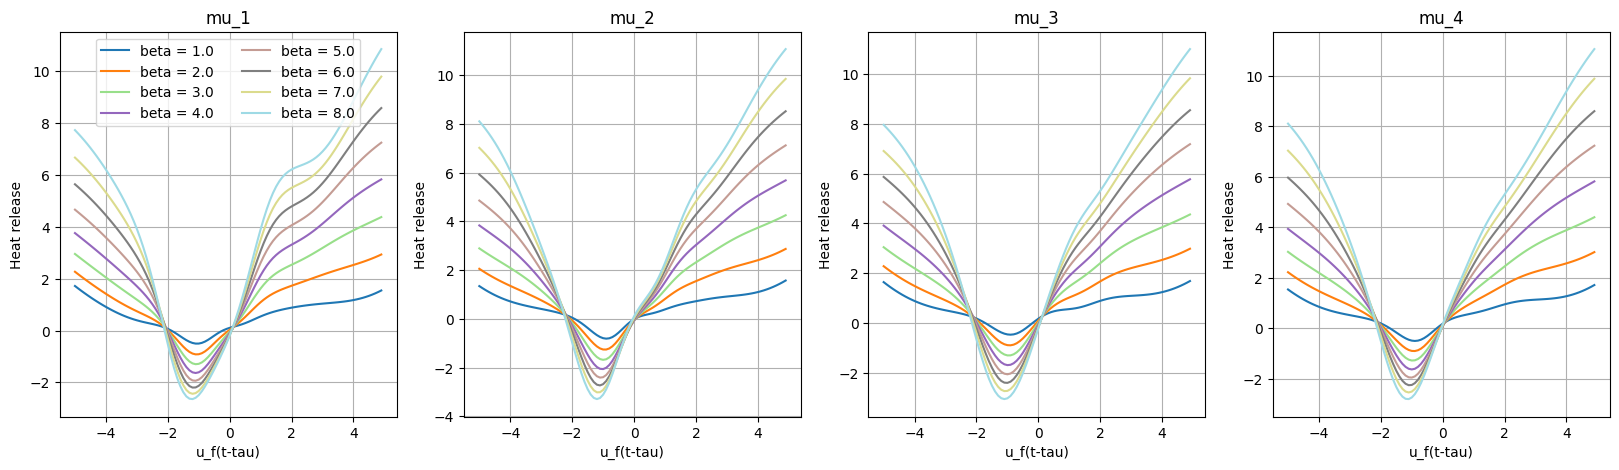

In [ ]:
from importlib import reload
from adjoint_esn import visualize_rijke_esn as visr
reload(visr)
visr.visualize_heat_release(my_ESN)

In [ ]:
my_ESN.train(DATA_f["train"]["u_washout"], 
             DATA_f["train"]["u"], 
             DATA_f["train"]["y"],
             P_washout=DATA_f["train"]["p_washout"], 
             P_train=DATA_f["train"]["p"],
             train_idx_list=train_idx_list)
W_out_f = my_ESN.W_out

In [ ]:
my_ESN.train(DATA_clean["train"]["u_washout"], 
             DATA_clean["train"]["u"], 
             DATA_clean["train"]["y"],
             P_washout=DATA_clean["train"]["p_washout"], 
             P_train=DATA_clean["train"]["p"],
             train_idx_list=train_idx_list)
W_out_clean = my_ESN.W_out

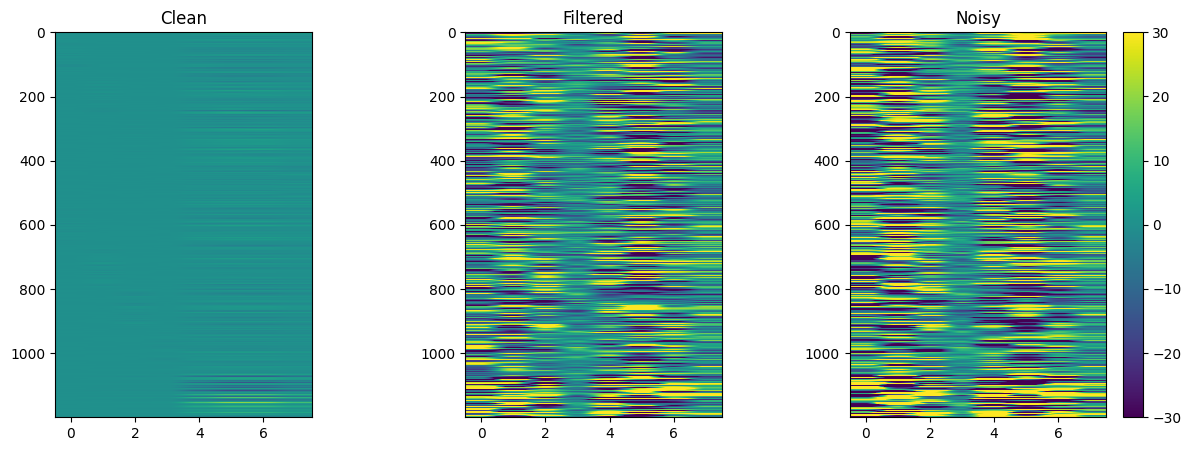

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(W_out_clean,aspect=0.01, vmin=-30, vmax=30)
plt.title("Clean")
plt.subplot(1,3,2)
plt.imshow(W_out_f,aspect=0.01, vmin=-30, vmax=30)
plt.title("Filtered")
plt.subplot(1,3,3)
plt.imshow(W_out_noisy,aspect=0.01, vmin=-30, vmax=30)
plt.title("Noisy")
plt.colorbar()


In [ ]:
tikh_list = [1e-6,1e-5,1e-4,1e-3]
W_out_list = [None]*len(tikh_list)
for i, tikh in enumerate(tikh_list):
    my_ESN.tikhonov = tikh
    my_ESN.train(DATA["train"]["u_washout"], 
                DATA["train"]["u"], 
                DATA["train"]["y"],
                P_washout=DATA["train"]["p_washout"], 
                P_train=DATA["train"]["p"],
                train_idx_list=train_idx_list)
    W_out_list[i] = my_ESN.W_out

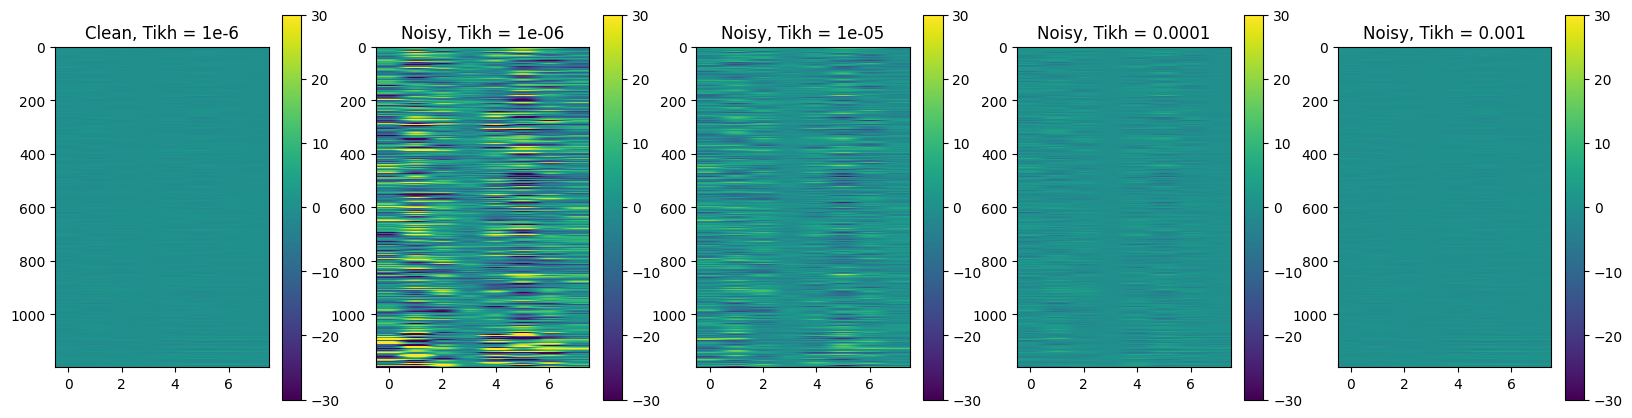

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,5,1)
plt.imshow(W_out_clean,aspect=0.01, vmin=-30, vmax=30)
plt.title(f"Clean, Tikh = 1e-6")
plt.colorbar()
for i in range(len(tikh_list)):
    plt.subplot(1,5,i+2)
    plt.imshow(W_out_list[i],aspect=0.01, vmin=-30, vmax=30)
    plt.title(f"Noisy, Tikh = {tikh_list[i]}")
    plt.colorbar()

In [ ]:
W_out_list = pp.unpickle_file('noisy_uy_W_out.pickle')[0]
my_ESN.W_out = np.mean(W_out_list,axis=0)

In [ ]:
which_train_idx = 0
my_ESN.W_out = W_out_f
my_ESN.tau = results["training_parameters"][which_train_idx][1]
x = my_ESN.open_loop_with_washout(U_washout=DATA_f["train"]["u_washout"][which_train_idx],P_washout=DATA_f["train"]["p_washout"][which_train_idx],
                                  U=DATA_f["train"]["u"][which_train_idx],P=DATA_f["train"]["p"][which_train_idx])
y_ol = np.matmul(x,my_ESN.W_out)
_, y_cl = my_ESN.closed_loop_with_washout(U_washout=DATA_clean["train"]["u_washout"][which_train_idx],
                                          P_washout=DATA_clean["train"]["p_washout"][which_train_idx],
                                          P=DATA_clean["train"]["p"][which_train_idx],
                                          N_t=len(DATA_clean["train"]["u"][which_train_idx]))

my_ESN.W_out = W_out_clean
my_ESN.tau = results["training_parameters"][which_train_idx][1]
x_clean = my_ESN.open_loop_with_washout(U_washout=DATA_clean["train"]["u_washout"][which_train_idx],P_washout=DATA_clean["train"]["p_washout"][which_train_idx],
                           U=DATA_clean["train"]["u"][which_train_idx],P=DATA_clean["train"]["p"][which_train_idx],)
_, y_cl_clean = my_ESN.closed_loop_with_washout(U_washout=DATA_clean["train"]["u_washout"][which_train_idx],
                                                P_washout=DATA_clean["train"]["p_washout"][which_train_idx],
                                                P=DATA_clean["train"]["p"][which_train_idx],
                                                N_t=len(DATA_clean["train"]["u"][which_train_idx]))


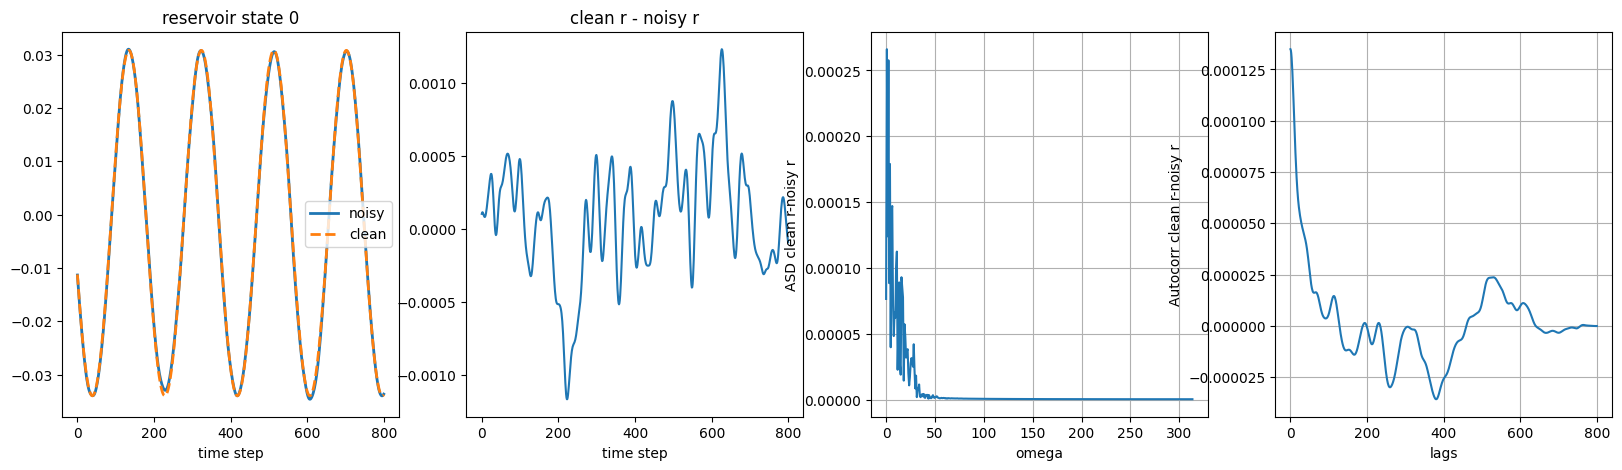

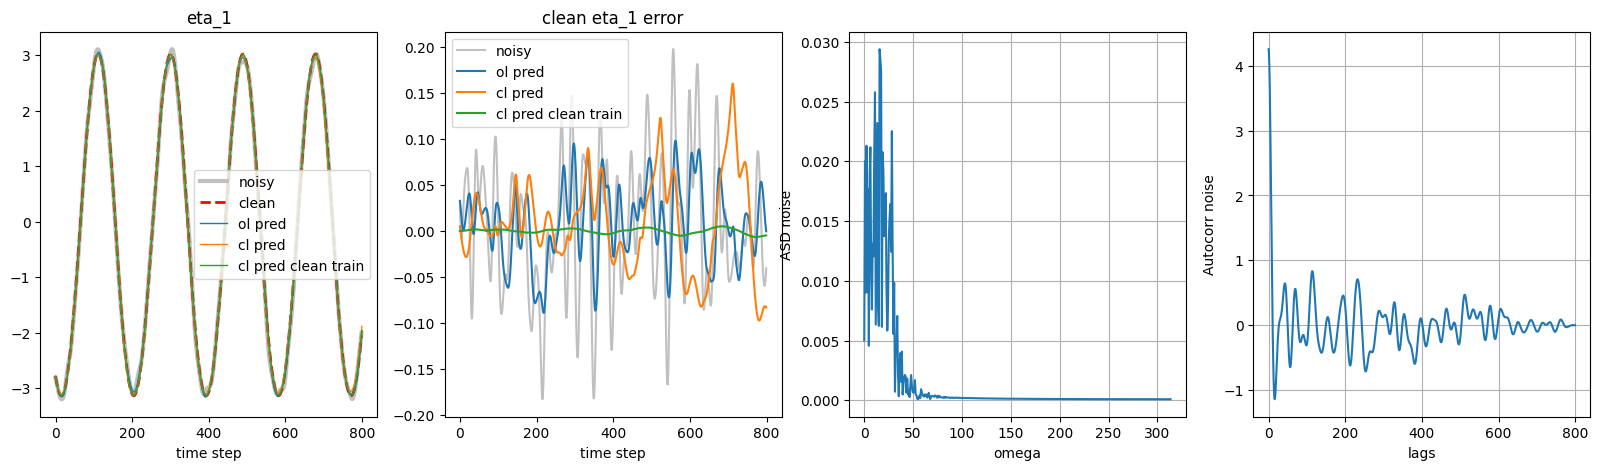

In [ ]:
r_idx = 0
var_idx = eInputVar.eta_1

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.plot(x[:-1,r_idx],linewidth=2)
plt.plot(x_clean[:-1,r_idx],'--',linewidth=2)
plt.xlabel('time step')
plt.title(f'reservoir state {r_idx}')
plt.legend(['noisy','clean'])

plt.subplot(1,4,2)
plt.plot(x_clean[:-1,r_idx]-x[:-1,r_idx])
plt.title('clean r - noisy r')
plt.xlabel('time step')

plt.subplot(1,4,3)
omega, asd_x_error = sig.amplitude_spectrum(x_clean[:-1,r_idx]-x[:-1,r_idx],network_dt)
plt.plot(omega,asd_x_error)
plt.xlabel('omega')
plt.ylabel('ASD clean r-noisy r')
plt.grid()

plt.subplot(1,4,4)
lags,xcorr_error = sig.xcorr(x_clean[:-1,r_idx]-x[:-1,r_idx],x_clean[:-1,r_idx]-x[:-1,r_idx],1)
plt.plot(lags[int(len(lags)/2):],xcorr_error[int(len(lags)/2):])
plt.xlabel('lags')
plt.ylabel('Autocorr clean r-noisy r')
plt.grid()


plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.plot(DATA_f["train"]["u"][which_train_idx][:,var_idx],linewidth=3,color='silver')
plt.plot(DATA_clean["train"]["u"][which_train_idx][:,var_idx],'--',linewidth=2,color='red')
plt.plot(y_ol[:,var_idx],linewidth=1,color='tab:blue')
plt.plot(y_cl[:,var_idx],linewidth=1,color='tab:orange')
plt.plot(y_cl_clean[:,var_idx],linewidth=1,color='tab:green')
plt.title(f'{var_idx.name}')
plt.xlabel('time step')
plt.legend(['noisy','clean','ol pred','cl pred','cl pred clean train'])

plt.subplot(1,4,2)
plt.plot(DATA_clean["train"]["u"][which_train_idx][:,var_idx]-DATA_f["train"]["u"][which_train_idx][:,var_idx],color='silver')
plt.plot(DATA_clean["train"]["u"][which_train_idx][:,var_idx]-y_ol[:-1,var_idx],color='tab:blue')
plt.plot(DATA_clean["train"]["u"][which_train_idx][:,var_idx]-y_cl[:-1,var_idx],color='tab:orange')
plt.plot(DATA_clean["train"]["u"][which_train_idx][:,var_idx]-y_cl_clean[:-1,var_idx],color='tab:green')
plt.title(f'clean {var_idx.name} error')
plt.legend(['noisy','ol pred','cl pred','cl pred clean train'])
plt.xlabel('time step')

plt.subplot(1,4,3)
noise = DATA_clean["train"]["u"][which_train_idx][:,var_idx]-DATA_f["train"]["u"][which_train_idx][:,var_idx]
omega, asd_noise = sig.amplitude_spectrum(noise,network_dt)
plt.plot(omega,asd_noise)
plt.xlabel('omega')
plt.ylabel('ASD noise')
plt.grid()

plt.subplot(1,4,4)
lags,xcorr_noise = sig.xcorr(noise,noise,1)
plt.plot(lags[int(len(lags)/2):],xcorr_noise[int(len(lags)/2):])
plt.xlabel('lags')
plt.ylabel('Autocorr noise')
plt.grid()

(0.0, 10.0)

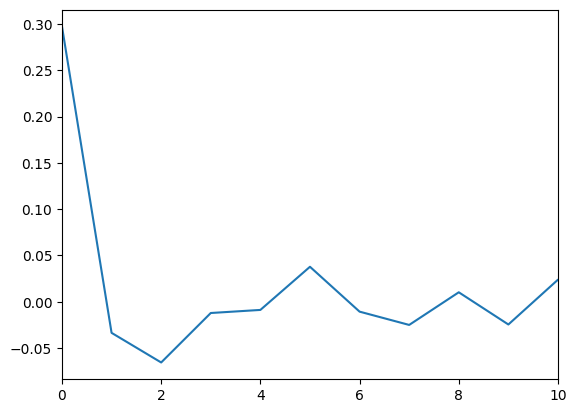

In [ ]:
plt.plot(lags[int(len(lags)/2):],xcorr_error[int(len(lags)/2):])
plt.xlim([0,10])

In [ ]:
R_noisy = np.empty((0, my_ESN.W_out_shape[0]))
for train_idx in train_idx_list:
    X_train_augmented_ = my_ESN.reservoir_for_train(
        DATA["train"]["u_washout"][train_idx],
        DATA["train"]["u"][train_idx],
        DATA["train"]["p_washout"][train_idx],
        DATA["train"]["p"][train_idx],
    )
    R_noisy = np.vstack((R_noisy, X_train_augmented_))

In [ ]:
Y_train_noisy = [DATA["train"]["y"][train_idx] for train_idx in train_idx_list]
Y_train_noisy = np.vstack(Y_train_noisy)

In [ ]:
C = np.hstack([R_noisy, Y_train_noisy])
U, S, Vh = np.linalg.svd(C)
V = Vh.T

In [ ]:
V11 = V[:input_dim,:input_dim]
V12 = V[:input_dim,input_dim:]
V21 = V[input_dim:,:input_dim]
V22 = V[input_dim:,input_dim:]
S1 = S[:input_dim]
S2 = S[input_dim:]

In [ ]:
R = np.empty((0, my_ESN.W_out_shape[0]))
for train_idx in train_idx_list:
    X_train_augmented_ = my_ESN.reservoir_for_train(
        DATA_clean["train"]["u_washout"][train_idx],
        DATA_clean["train"]["u"][train_idx],
        DATA_clean["train"]["p_washout"][train_idx],
        DATA_clean["train"]["p"][train_idx],
    )
    R = np.vstack((R, X_train_augmented_))

## Computational cost

In [238]:
# Running original solver
beta = 2.0
tau = 0.25
x_f = 0.2
N_c = 10
my_rijke = Rijke(
            N_g=N_g,
            N_c=N_c,
            c_1=0.1,
            c_2=0.06,
            beta=beta,
            x_f=x_f,
            tau=tau,
            heat_law="kings_poly",
            damping="modal",
        )
# run simulation
y0_init = np.zeros(2*N_g+N_c)
y0_init[0] = 1.0

# temporal grid
sim_time = 1
t = np.arange(0, sim_time, sim_dt)

# solve ODE using odeint
%timeit solve_ode.integrate(my_rijke.ode, y0_init, t)

38.9 ms ± 5.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [239]:
y = solve_ode.integrate(my_rijke.ode, y0_init, t)
%timeit sens.true_adjoint_sensitivity(my_rijke, t, y, integrator)

60.5 ms ± 7.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
# Training ESN
%timeit my_ESN.train(DATA["train"]["u_washout"], DATA["train"]["u"], DATA["train"]["y"], P_washout=DATA["train"]["p_washout"], P_train=DATA["train"]["p"],train_idx_list=train_idx_list)

4.39 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [97]:
# Running ESN
p_sim = {'beta':beta, 'tau':tau}
y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=transient_time+washout_time+sim_time,sim_dt=sim_dt,
                                data_dir=data_dir, y_init = None)

data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=[sim_time],
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        start_idxs=None,
                        noise_level=0.0,
                        random_seed=random_seed,
                        tau=p_sim["tau"])

if hasattr(my_ESN,"tau"):
    my_ESN.tau = p_sim["tau"]
    
# %timeit my_ESN.closed_loop_with_washout(U_washout=data["loop_0"]["u_washout"], N_t=len(data["loop_0"]["u"]), P_washout=data["loop_0"]["p_washout"],  P=data["loop_0"]["p"])

x0_washout = np.zeros(my_ESN.N_reservoir)
X_tau_0 = my_ESN.open_loop(
                x0=x0_washout,
                U=data["loop_0"]["u_washout"],
                P=data["loop_0"]["p_washout"],
            )
X_tau_1 = X_tau_0[-my_ESN.N_tau - 1 :]
P_new = np.vstack(
    (
        data["loop_0"]["p_washout"][-my_ESN.N_tau - 1 :, :],
        data["loop_0"]["p"],
    )
)
N = len(data["loop_0"]["u"])
%timeit my_ESN.closed_loop(X_tau_1, N_t=N, P=P_new)

29.5 ms ± 4.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [98]:
x_pred, y_pred = my_ESN.closed_loop(X_tau_1, N_t=N, P=P_new)
%timeit my_ESN.adjoint_sensitivity(x_pred, y_pred, N, X_tau_1, fast_jac=True)

2.4 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [103]:
%timeit my_ESN.finite_difference_sensitivity_x0(x_pred, y_pred, X_tau_1, P_new, N, h=1e-5, method="central")

57.4 s ± 1.29 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [104]:
%timeit my_ESN.direct_sensitivity_x0(x_pred, y_pred, N, fast_jac=True)

7.63 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [105]:
%timeit my_ESN.adjoint_sensitivity_x0(x_pred, y_pred, N, fast_jac=True)

1.34 s ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [233]:
dtanh = my_ESN.dtanh(x_pred[1],x_pred[0])
%timeit my_ESN.fast_jac(dtanh)

5.44 ms ± 783 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [237]:
dfdx_const = my_ESN.dfdx_const.copy()
def fast_jac2(dtanh):
    """Faster implementation of the Jacobian for the basic ESN
    Only valid when input_only_mode = False and r2_mode = False
    """
    dfdx = np.multiply(dfdx_const, dtanh)
    # dfdx.ravel()[:: dfdx.shape[1] + 1] += 1 - my_ESN.alpha
    return dfdx
%timeit fast_jac2(dtanh)

6.2 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [246]:
d = 1200
# Generate random matrices
jac_const = np.random.randn(d, d)
dtanh = np.random.randn(1, d)

%timeit jac = np.multiply(jac_const, dtanh)

11.2 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [231]:
import time
d_arr = [int(i) for i in np.linspace(1,2000,100)]
d_arr = [1,2,5,10,30,50,75,100,300,500,750,1000,1250,1500,1750,2000]
exec_time = np.zeros(len(d_arr))
for d_idx, d in enumerate(d_arr):
    a1 = np.random.randn(d,d)
    a2 = np.random.randn(d)
    for _ in range(10):
        start_time = time.time()
        b1 = np.multiply(a1,a2)  
        exec_time[d_idx] += time.time() - start_time

exec_time = exec_time/10
# %timeit np.multiply(a1,a2)
# %timeit np.matmul(a1, np.diag(a2))
# %timeit np.einsum('ij,j->ij',a1,a2)

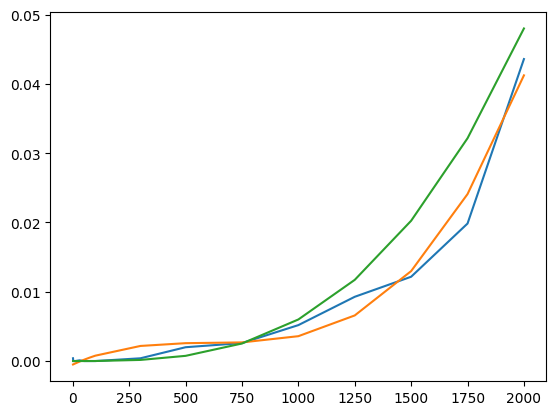

In [232]:
dd_arr = np.array(d_arr, dtype=np.float64)
plt.plot(dd_arr,exec_time)

coeff = np.polyfit(dd_arr,exec_time,deg=3)
exec_time_fit = np.polyval(coeff,dd_arr)
plt.plot(dd_arr,exec_time_fit)
plt.plot(dd_arr,6e-12 * dd_arr**3)
# plt.xscale('log')

## Test ESN

In [ ]:
u_washout_auto = DATA["train"]["u_washout"][0]
u_washout_auto = np.repeat(DATA["train"]["u_washout"][0][0,:][None,:], [len(DATA["train"]["u_washout"][0])], axis = 0)

y0 = np.zeros((1,DATA["train"]["u_washout"][0].shape[1]))
eta_1_init = 1.5
y0[0,0] = eta_1_init
# y0[0,:2*N_g] = eta_1_init*np.random.randn(1, 2*N_g)

u_washout_auto = np.repeat(y0, [len(DATA["train"]["u_washout"][0])], axis = 0)

y_init = np.zeros(2*N_g+10)
y_init[:2*N_g] = y0[0,:2*N_g]
# y_init = eta_1_init*np.random.randn(2*N_g+10)

In [ ]:
my_ESN.W_out = W_out_clean

1.0


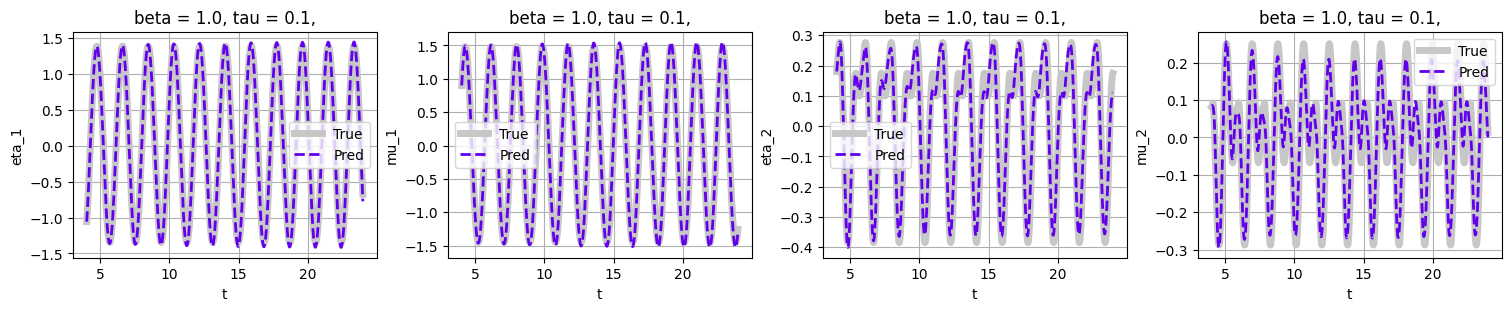

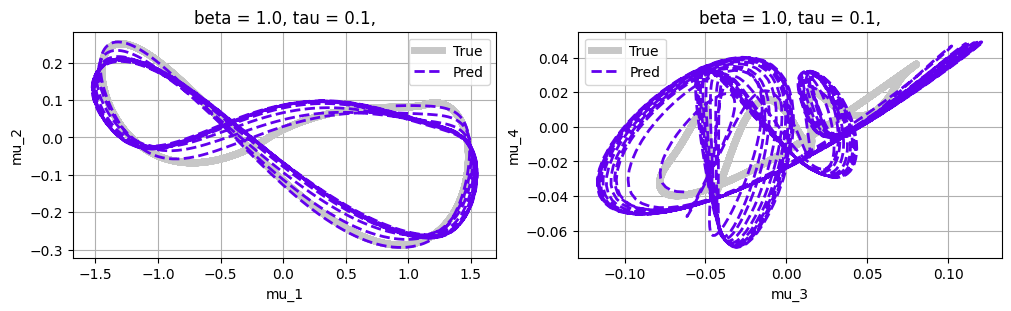

In [22]:
# colors = ["#6200EE","#03DAC6"]
# colors = ["silver","#6200EE","#03DAC6"]
colors = ["#C7C7C7","#6200EE","#03DAC6"]
# colors = ["silver","grey","black"]
# colors = ["silver"]
nice_purples =["#8000FF","#9429FF","#8328FC","#7D36FC","#6200EE"]
nice_blues=["#03DAC6","#00F6B6","#0FE7D2","#5AE8CD","#69D9CC"]
nice_oranges=["#F0BB94"]
ls = ["-","--"]
lw = [5,2]

sim_time = 250#config.simulation.sim_time
loop_times = [20]
beta_list = [1.0]
tau_list = [0.1]

plt_idx = [eOutputVar.eta_1,eOutputVar.mu_1,eOutputVar.eta_2,eOutputVar.mu_2]
plt_idx_pairs = [[eOutputVar.mu_1,eOutputVar.mu_2],
                 [eOutputVar.mu_3,eOutputVar.mu_4],]
phase_space_steps = pp.get_steps(100,network_dt)

error_measure = errors.rel_L2

p_list = pp.make_param_mesh([beta_list,tau_list])

# p_list = results["training_parameters"]
for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir, y_init = None)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        start_idxs=None,
                        noise_level=0.0,
                        random_seed=random_seed,
                        tau=p_sim["tau"])

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]

    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        print(data[loop_name]["p"][0][0])
        y_pred = y_pred[1:]
        regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]},'

        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_lines(data[loop_name]["t"],data[loop_name]["y"][:,k],
                           y_pred[:,k],
                        title=regime_str,
                        xlabel='t',
                        ylabel=k.name,
                        linestyle=ls,
                        linewidth=lw,
                        color=colors,
                        legend=['True','Pred'])
            
        plt.figure(figsize = (10,3),constrained_layout=True)
        for j, k in enumerate(plt_idx_pairs):
            plt.subplot(1,len(plt_idx_pairs),j+1)
            vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps:],
                             y_pred[-phase_space_steps:],
                             idx_pair=k,
                             title=regime_str,
                             linestyle=ls,
                             linewidth=lw,
                             color=colors,
                             legend=['True','Pred'])
            plt.xlabel(k[0].name)
            plt.ylabel(k[1].name)

        # print('Regime:',regime_str,'Error:', error_measure(data[loop_name]["y"],y_pred))

In [ ]:
y01 = np.zeros((1,DATA["train"]["u_washout"][0].shape[1]))
y02 = np.zeros((1,DATA["train"]["u_washout"][0].shape[1]))
eta_1_init = 1.0
y01[0,0] = eta_1_init
y02[0,0] = eta_1_init+0.00001
u_washout_auto1 = np.repeat(y01, [len(DATA["train"]["u_washout"][0])], axis = 0)
u_washout_auto2 = np.repeat(y02, [len(DATA["train"]["u_washout"][0])], axis = 0)

y_init1 = np.zeros(2*N_g+10)
y_init1[:2*N_g] = y01[0,:2*N_g]

y_init2 = np.zeros(2*N_g+10)
y_init2[:2*N_g] = y02[0,:2*N_g]

_, y_pred1 = my_ESN.closed_loop_with_washout(U_washout=u_washout_auto1, 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])

_, y_pred2 = my_ESN.closed_loop_with_washout(U_washout=u_washout_auto2, 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])

y_true1, _ = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                            sim_time=loop_times[0],sim_dt=network_dt,
                            data_dir=Path('dd'), y_init = y_init1)
y_true2, _ = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                            sim_time=loop_times[0],sim_dt=network_dt,
                            data_dir=Path('dd'), y_init = y_init2)

Text(0, 0.5, 'error')

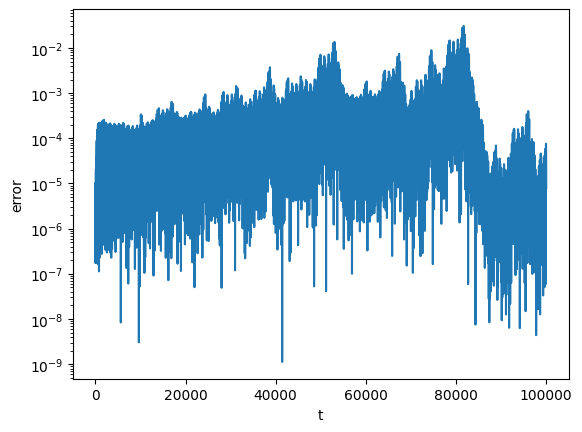

In [ ]:
plt.plot(np.abs(y_true1[:,0]-y_true2[:,0]))
# plt.plot(np.linalg.norm(y_pred1-y_pred2,axis=1))
plt.yscale('log')
plt.xlabel('t')
plt.ylabel('error')

Omega =  3.28962581527727
Period =  1.9100000000000001
Omega =  3.28962581527727
Period =  1.9100000000000001


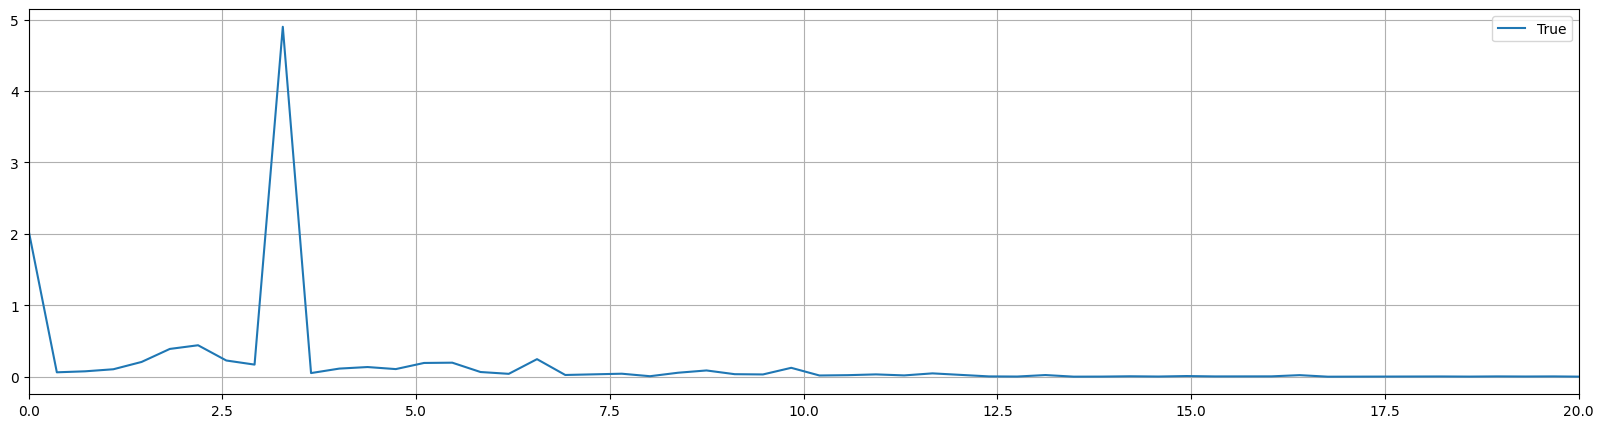

Omega peaks:  [ 2.18545576  3.27818364  4.37091152  5.09939677  6.55636728  7.64909516
  8.74182304  9.83455092 10.9272788  11.65576405 13.11273455 14.20546243
 14.93394769 16.39091819 18.21213133 18.94061658 19.66910183 21.49031496
 22.21880022 22.94728547 26.22546911 32.78183639 34.96729214]
Period peaks:  [2.875      1.91666667 1.4375     1.23214286 0.95833333 0.82142857
 0.71875    0.63888889 0.575      0.5390625  0.47916667 0.44230769
 0.42073171 0.38333333 0.345      0.33173077 0.31944444 0.29237288
 0.28278689 0.27380952 0.23958333 0.19166667 0.1796875 ]
Ratio of omega_0/ omega_1;  2/3
Ratio of omega_1/ omega_2;  3/4
Ratio of omega_2/ omega_3;  6/7


In [ ]:
from adjoint_esn.utils import signals
from scipy.signal import find_peaks

def get_psd(dt, y, periodic = False):
    if periodic:
        T_period = signals.period(y, dt)
        omega_period = 2 * np.pi / T_period
        print("Omega = ", omega_period)
        print("Period = ", T_period)
        # take the maximum number of periods
        # the real period isn't an exact multiple of the sampling time
        # therefore, the signal doesn't repeat itmy_ESN at exact integer indices
        # so calculating the number of time steps in each period
        # does not work in order to cut the signal at the maximum number of periods
        # that's why we will cut between peaks, which is a more reliable option
        # though still not exact
        min_dist = pp.get_steps(T_period - 0.1, dt)
        (start_pk_idx, end_pk_idx) = signals.periodic_signal_peaks(y, T=min_dist)
        y_pre_fft = y[start_pk_idx:end_pk_idx] # don't include end peak for continuous signal
    else:
        y_pre_fft = y

    # find psd
    omega, psd = signals.amplitude_spectrum(y_pre_fft, dt)

    # to get the harmonic frequency from the psd
    # psd_peaks = find_peaks(psd, threshold=0.1)[0] 
    # harmonic_freq = omega[psd_peaks][0]
    return omega, psd

periodic = True

# Plot power spectral density
omega, psd = get_psd(network_dt, data[loop_name]["y"][:,0], periodic=periodic)
omega_pred, psd_pred = get_psd(network_dt, y_pred[:,0], periodic=periodic)
plt.figure(figsize=(20,5))
plt.plot(omega, psd)
# plt.plot(omega_pred, psd_pred,'--')
pks = signal.find_peaks(psd_pred, threshold=0.0005)[0]
pks_omega = omega_pred[pks]
pks_psd = psd_pred[pks]
# plt.scatter(pks_omega,pks_psd, color='red')
plt.grid()
plt.legend(["True","ESN"])
plt.xlim([0,20])
plt.show()
print("Omega peaks: ", pks_omega)
pks_period = 2*np.pi / pks_omega
print("Period peaks: ", pks_period)

from fractions import Fraction
# rational approximation
print("Ratio of omega_0/ omega_1; ", Fraction((pks_omega[0]/pks_omega[1])).limit_denominator())
print("Ratio of omega_1/ omega_2; ", Fraction((pks_omega[1]/pks_omega[2])).limit_denominator())
print("Ratio of omega_2/ omega_3; ", Fraction((pks_omega[2]/pks_omega[3])).limit_denominator())
# print("Ratio of omega_3/ omega_4; ", Fraction((pks_omega[3]/pks_omega[4])).limit_denominator())

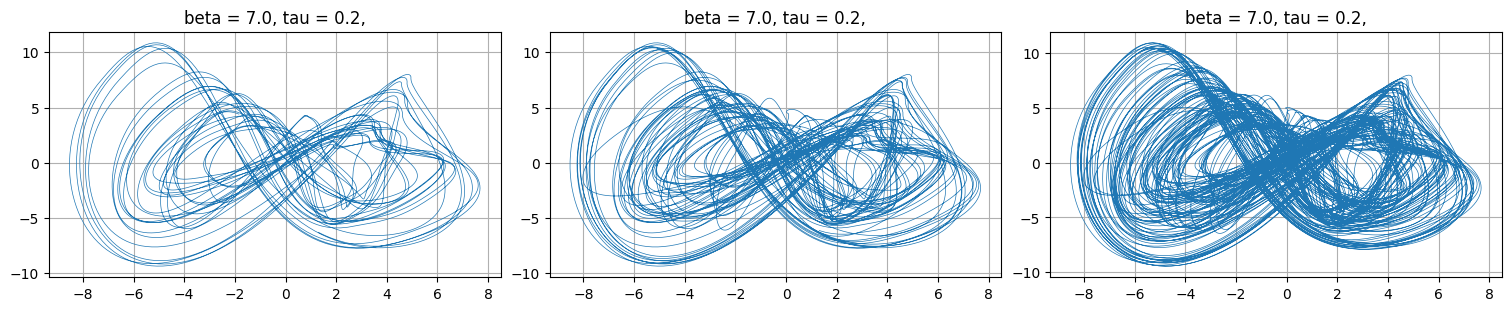

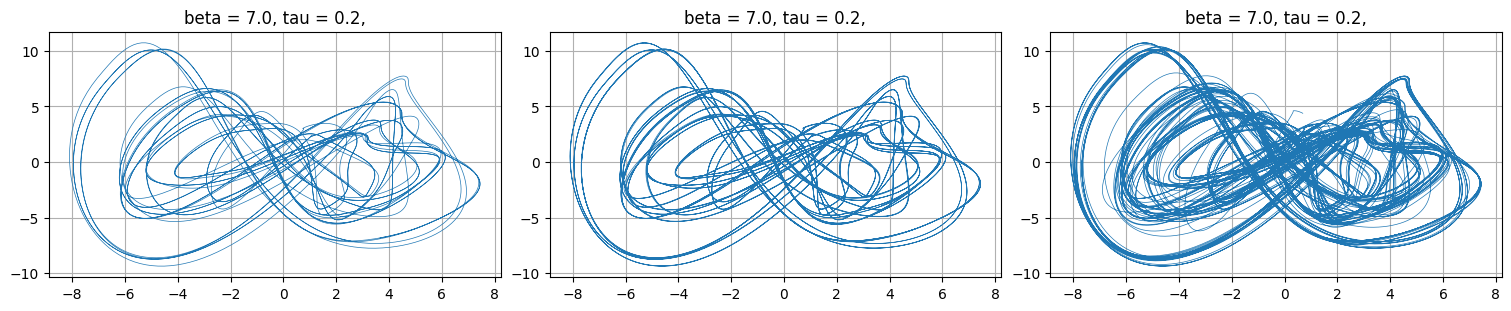

In [ ]:
phase_space_steps1 = pp.get_steps(50,network_dt)
phase_space_steps2 = pp.get_steps(100,network_dt)
phase_space_steps3 = pp.get_steps(1000,network_dt)

k = plt_idx_pairs[0]
lw = 0.5
plt.figure(figsize = (15,3),constrained_layout=True)
plt.subplot(1,3,1)
vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps1:],idx_pair=k,title=regime_str,linewidth=[lw])

plt.subplot(1,3,2)
vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps2:],idx_pair=k,title=regime_str,linewidth=[lw])

plt.subplot(1,3,3)
vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps3:],idx_pair=k,title=regime_str,linewidth=[lw])

plt.figure(figsize = (15,3),constrained_layout=True)
plt.subplot(1,3,1)
vis.plot_phase_space(y_pred[-phase_space_steps1:],idx_pair=k,title=regime_str,linewidth=[lw])

plt.subplot(1,3,2)
vis.plot_phase_space(y_pred[-phase_space_steps2:],idx_pair=k,title=regime_str,linewidth=[lw])

plt.subplot(1,3,3)
vis.plot_phase_space(y_pred[-phase_space_steps3:],idx_pair=k,title=regime_str,linewidth=[lw])


## Triggering

Running solver.
Running solver.


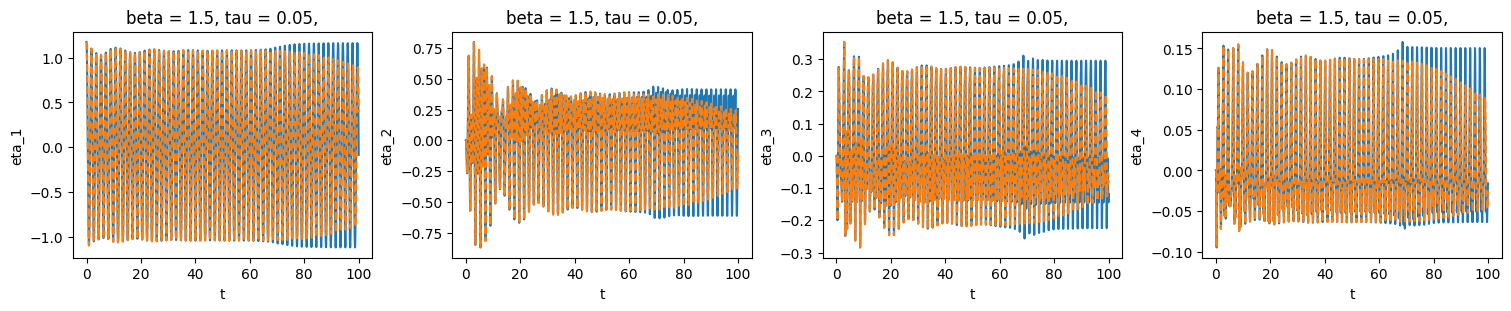

In [ ]:
sim_time = 100
p_sim = {'beta':1.5, 'tau':0.05}
regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]},'

y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                            sim_time=sim_time,sim_dt=sim_dt,
                            data_dir=data_dir, eta_1_init = 1.176447586)
plt.figure(figsize = (15,3),constrained_layout=True) 
for j, k in enumerate(plt_idx):
    plt.subplot(1,len(plt_idx),j+1)
    vis.plot_lines(t_sim,y_sim[:,k],
                title=regime_str,
                xlabel='t',
                ylabel=k.name,
                linestyle=['-'])
    
y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                            sim_time=sim_time,sim_dt=sim_dt,
                            data_dir=data_dir, eta_1_init = 1.176447485)
# plt.figure(figsize = (15,3),constrained_layout=True)                          
for j, k in enumerate(plt_idx):
    plt.subplot(1,len(plt_idx),j+1)
    vis.plot_lines(t_sim,y_sim[:,k],
                title=regime_str,
                xlabel='t',
                ylabel=k.name,
                linestyle=['--'])


## Statistics

Simulation not long enough: 2300>1200.0


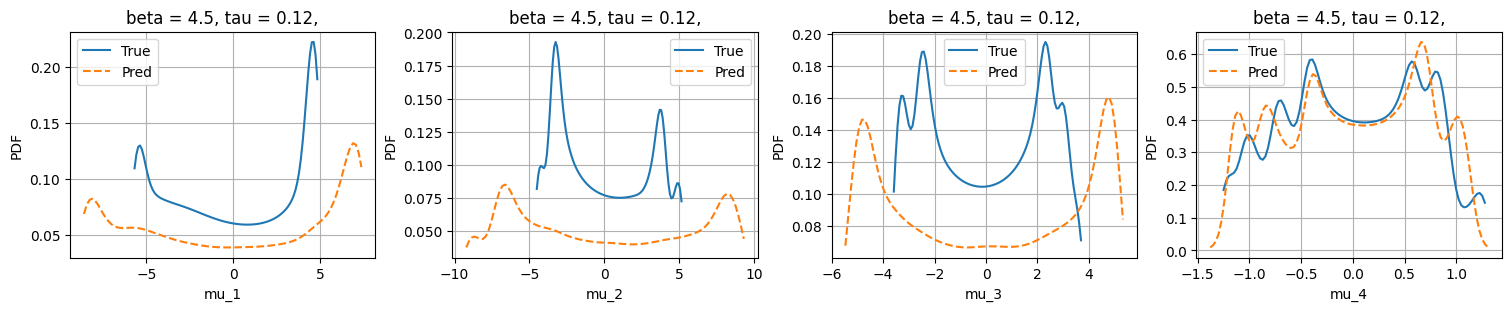

In [ ]:
sim_time = 2300
loop_times = [2000]

beta_list =  [4.5]
tau_list = [0.12]
p_list = pp.make_param_mesh([beta_list,tau_list])

# plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.mu_1,eOutputVar.mu_2]
# plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.eta_3,eOutputVar.eta_4]
plt_idx = [eOutputVar.mu_1,eOutputVar.mu_2,eOutputVar.mu_3,eOutputVar.mu_4]
for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        tau=p_sim["tau"])

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=u_washout_auto, #data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]
        regime_str = f"beta = {p_list[p_idx][eParam.beta]}, tau = {p_list[p_idx][eParam.tau]},"

        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_statistics(data[loop_name]["y"][:,k],y_pred[:,k],
                                title=regime_str,
                                xlabel=k.name,
                                ylabel='PDF',
                                linestyle=['-','--'],
                                legend=['True','Pred'])

## Stability analysis

In [ ]:
import adjoint_esn.utils.lyapunov as lyap
from adjoint_esn.rijke_galerkin.solver import Rijke

sim_time = 250
sim_dt = 1e-2
loop_times = [12]
transient_time_ly = 10

p_sim = {'beta':7.2, 'tau':0.2}

rjk = Rijke(
    N_g=4,
    N_c=10,
    c_1=0.1,
    c_2=0.06,
    beta=p_sim["beta"],
    x_f=0.2,
    tau=p_sim["tau"],
    heat_law='kings_poly',
    damping='modal',
)
y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                            sim_time=sim_time,sim_dt=sim_dt,
                            data_dir=data_dir,
                            integrator='rk4')
N_transient = pp.get_steps(transient_time,sim_dt)
y_bar = y_sim[N_transient:,:]
t_bar = t_sim[N_transient:]

N_washout = pp.get_steps(washout_time,sim_dt)
N_loop = pp.get_steps(loop_times[0],sim_dt)+1
y_bar = y_bar[N_washout:N_washout + N_loop,:]
t_bar = t_bar[N_washout:N_washout + N_loop]-t_bar[N_washout]
y_bar = y_bar[:,:rjk.N_dim]

data = pp.create_dataset(y_sim,t_sim,p_sim,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    loop_times=loop_times,
                    input_vars=input_vars,
                    output_vars=output_vars,
                    param_vars=param_vars,
                    N_g=N_g,
                    u_f_order=u_f_order,
                    tau=p_sim["tau"])

LEs_true, FTLE_true, QQ_true, RR_true = lyap.calculate_LEs(sys=rjk,
                                 sys_type='continuous',
                                 X=y_bar,
                                 t=t_bar,
                                 transient_time=transient_time_ly,
                                 dt=sim_dt,
                                 target_dim=None,
                                 norm_step=1)
LEs_target = LEs_true[-1]
print('Lyapunov exponents true:', LEs_target)
print('Lyapunov time true:', 1/LEs_target[0])
# CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ_true,RR_true,sim_dt)

if hasattr(my_ESN,"tau"):
    my_ESN.tau = p_sim["tau"]

x0_washout = np.zeros(my_ESN.N_reservoir)
X_past = my_ESN.open_loop(
                x0=x0_washout,
                U=data["loop_0"]["u_washout"],
                P=data["loop_0"]["p_washout"],
            )
X_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data["loop_0"]["u_washout"], 
                                            N_t=len(data["loop_0"]["u"]), 
                                            P_washout=data["loop_0"]["p_washout"],  
                                            P=data["loop_0"]["p"])

LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_ESN,
                                 sys_type='RijkeESN',
                                 X=X_pred,
                                 X_past=X_past,
                                 t=data[loop_name]["t"]-data[loop_name]["t"][0],
                                 transient_time=transient_time_ly,
                                 dt=network_dt,
                                 target_dim=my_ESN.N_dim,
                                 norm_step=1)
LEs_target = LEs[-1]
print('Lyapunov exponents:', LEs_target)
print('Lyapunov time:', 1/LEs_target[0])
# CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,dt)

Lyapunov exponents true: [ -0.31865474  -0.07798743   0.1741384   -0.07661461  -0.79810232
  -0.5642839   -0.54514219  -0.65478188 -16.33875435 -19.61600667
 -19.18873742 -19.14154114 -22.5838163  -22.45300152 -28.75093001
 -43.40927274 -67.01858483 -76.44671523]
Lyapunov time true: -3.138192744198856
Lyapunov exponents: [ 0.24545215 -0.3046651  -0.50842813 -0.15862536 -0.43844888 -0.93833594
 -0.58474631 -0.79921904]
Lyapunov time: 4.0741137514324794


In [ ]:
def QR(M, N_exp):
    ''' Compute an orthogonal basis, Q,
        and the exponential change in the norm along each element of the basis, S. '''

    Q    = [None]*N_exp
    S    = np.empty(N_exp)

    S[0] = np.linalg.norm(M[0])    
    Q[0] = M[0] / S[0]

    for i in range(1,N_exp):
        
        #orthogonalize
        temp = 0
        for j in range(i):
            temp += np.dot(Q[j],M[i])*Q[j]   
        Q[i]  = M[i] - temp
        
        #normalize
        S[i]  = np.linalg.norm(Q[i])   #increase of the perturbation along i-th direction
        Q[i] /= S[i] 

    return Q, np.log(S)

N_g = 4
N_c = 10
beta = 7.6
tau = 0.22
x_f = 0.2
sim_dt = 1e-3

transient_time = 200
sim_time = 100
N = pp.get_steps(sim_time, sim_dt)
orth_time = 1e-3
N_orth = pp.get_steps(orth_time, sim_dt)
N_times = N // N_orth

my_rijke = Rijke(
            N_g=N_g,
            N_c=N_c,
            c_1=0.1,
            c_2=0.06,
            beta=beta,
            x_f=x_f,
            tau=tau,
            heat_law="kings_poly",
            damping="modal",
        )
# run simulation
y0_init = np.zeros(2*N_g+N_c)
y0_init[0] = 1.0

# temporal grid
t = np.arange(0, transient_time + sim_dt, sim_dt)

# solve ODE using odeint
q0 = solve_ode.integrate(my_rijke.ode, y0_init, t)[-1]

eps = 1e-9

N_exp = 2*N_g + N_c
N_dim = 2*N_g + N_c
SS = np.empty((N_times, N_exp))
x0P = []
for ii in range(N_exp):
    q_per = np.random.rand(N_dim)
    x0P += [ q0 + eps*(q_per/np.linalg.norm(q_per)) ] 

t_orth = np.arange(0, orth_time + sim_dt, sim_dt)

S = 0
for jj in range(N_times):
    
    if jj > 0:
        for ii in range(N_exp):
            x0P[ii] = q0 + eps*aa[ii] #perturb initial condition with orthonormal basis
    
    q0  = solve_ode.integrate(my_rijke.ode, q0, t_orth)[-1] #compute unperturbed trajectory                   
    for ii in range(N_exp):
        x0P[ii] = solve_ode.integrate(my_rijke.ode, x0P[ii], t_orth)[-1] #compute perturbed trajectories   
            
    a  = []
    for ii in range(N_exp):        
        a += [(x0P[ii] - q0)/eps] #compute the final value of the N_exp perturbations

    aa, S1 = QR(a, N_exp) #orthornormalize basis and compute exponents
    
    if jj > 0:  #skip the first step, which does not start from the orthonormalized basis
        S += S1
        SS[jj] = S/(jj*sim_dt*N_orth)

Lyap_exp = SS[-1]
print('Lyapunov exponents', Lyap_exp)

## Bifurcation diagram

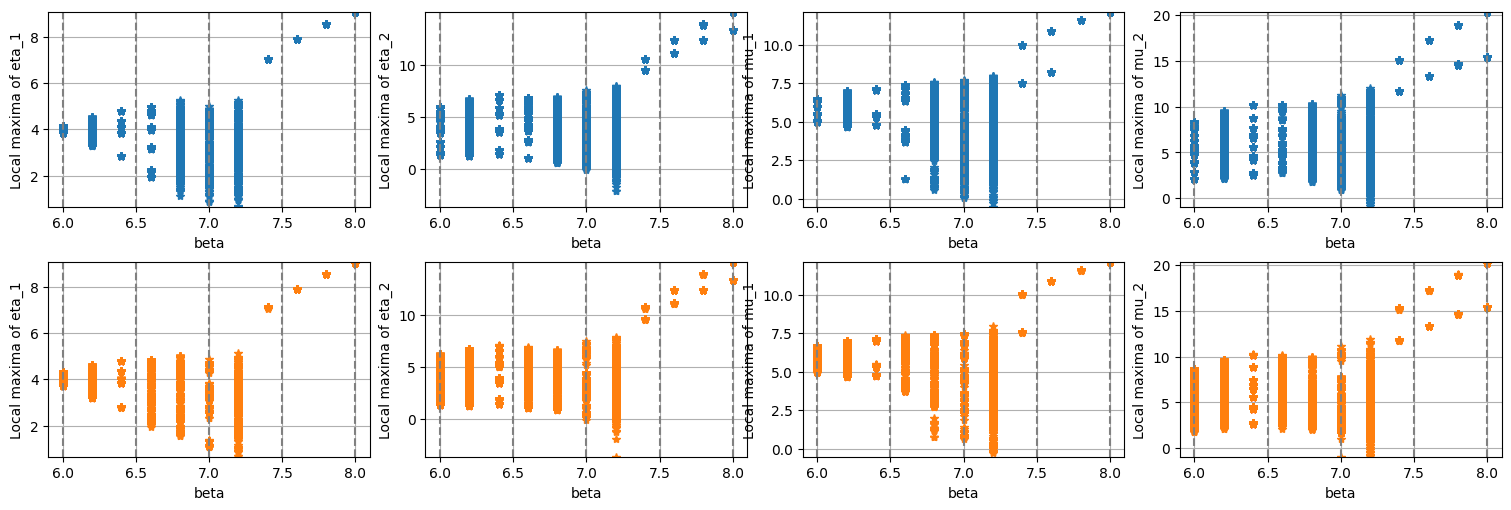

In [ ]:
sim_time = 1200
loop_times = [800]

beta_list = np.arange(6.0,8.2,0.2)
tau_list = [0.2]

if len(beta_list) > 1 and len(tau_list) == 1:
    vary_param = 'beta'
elif len(beta_list) == 1 and len(tau_list) > 1:
    vary_param = 'tau'
else:
    raise ValueError("For this plot one parameter needs to be varying and the other fixed.")
p_list = pp.make_param_mesh([beta_list,tau_list])

vary_param_train = list(set(train_param_list[train_idx_list,eParam[vary_param]]))

plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.mu_1,eOutputVar.mu_2]

fig, ax = plt.subplots(nrows=2, 
                        ncols=len(plt_idx), 
                        figsize=(15,5), 
                        constrained_layout=True)

# track minimum and maximum values of the peaks 
pks_min = np.inf*np.ones((len(p_list),len(plt_idx)))   
pks_max = -np.inf*np.ones((len(p_list),len(plt_idx)))   

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        tau=p_sim["tau"])
    
    loop_name = list(data.keys())[0]

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    
    _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                N_t=len(data[loop_name]["u"]), 
                                                P_washout=data[loop_name]["p_washout"],  
                                                P=data[loop_name]["p"])
    y_pred = y_pred[1:]

    for j, k in enumerate(plt_idx):
        plt.sca(ax[0,j])
        pks_true = vis.plot_bifurcation_diagram(p_sim[vary_param], data[loop_name]["y"][:,k], 
                                        color='tab:blue', 
                                        marker='*', 
                                        linestyle='None')
        min_pks_true = np.min(pks_true)
        max_pks_true = np.max(pks_true)

        plt.sca(ax[1,j])
        pks_pred = vis.plot_bifurcation_diagram(p_sim[vary_param], y_pred[:,k],
                                        color='tab:orange', 
                                        marker='*', 
                                        linestyle='None')
        min_pks_pred = np.min(pks_pred)
        max_pks_pred = np.max(pks_pred)

        pks_min[p_idx,j] = min(pks_min[p_idx,j], min(min_pks_true,min_pks_pred))
        pks_max[p_idx,j] = max(pks_max[p_idx,j], max(max_pks_true,max_pks_pred))

for j, k in enumerate(plt_idx):
    for i in range(ax.shape[0]):
        ylims = [np.min(pks_min[:,j]),np.max(pks_max[:,j])]
        ax[i,j].set_ylim(ylims)
        ax[i,j].set_xlabel(vary_param)
        ax[i,j].set_ylabel(f"Local maxima of {k.name}")
        ax[i,j].vlines(vary_param_train, ymin=ylims[0], ymax=ylims[1], color = "grey", linestyles='dashed')
        ax[i,j].grid()

## Hopf bifurcation curve

In [ ]:
def acoustic_energy(y, N_g):
    return 1/4*np.mean(np.sum(y[:,:2*N_g]**2, axis = 1))

In [ ]:
sim_time = 400
loop_times = [100]

beta_list = np.arange(0.2,2.5,0.1)
tau_list = np.arange(0.05,0.1,0.01)

def energy_decreased(y, N_g, percent_threshold = 5):
    half_steps = int(np.round(len(y)/2))
    e1 = acoustic_energy(y[:half_steps],N_g)
    e2 = acoustic_energy(y[half_steps:],N_g)
    return e1-e2 > (percent_threshold/100)*e1 or e2 < 5e-4

percent_threshold = 5
p_energy_decreased = partial(energy_decreased, N_g=N_g, percent_threshold=percent_threshold)
bifn_point_true = np.zeros(len(tau_list))
bifn_point_pred = np.zeros(len(tau_list))

for tau_idx, tau in enumerate(tau_list):
    for beta_idx, beta in enumerate(beta_list): 
        p_sim = {'beta':beta, 'tau':tau}
        y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                    sim_time=sim_time,sim_dt=sim_dt,
                                    data_dir=data_dir)

        data = pp.create_dataset(y_sim,t_sim,p_sim,
                            network_dt=network_dt,
                            transient_time=transient_time,
                            washout_time=washout_time,
                            loop_times=loop_times,
                            input_vars=input_vars,
                            output_vars=output_vars,
                            param_vars=param_vars,
                            N_g=N_g,
                            u_f_order=u_f_order)
        
        loop_name = list(data.keys())[0]

        if hasattr(my_ESN,"tau"):
            my_ESN.tau = p_sim["tau"]

        y0 = np.zeros((1,data[loop_name]["u_washout"].shape[1]))
        y0[0] = 1.0
        u_washout_auto = np.repeat(y0, [len(data[loop_name]["u_washout"])], axis = 0)
        transient_steps = pp.get_steps(transient_time, network_dt)
        # add the transient time that will be discarded later
        N_t_long = transient_steps + len(data[loop_name]["u"])
        p_long0 = np.zeros((1,data[loop_name]["p"].shape[1]))
        p_long0[0] = data[loop_name]["p"][0]
        p_long = np.repeat(p_long0, [N_t_long], axis = 0)
        
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=u_washout_auto, 
                                                        N_t=N_t_long, 
                                                        P_washout=data[loop_name]["p_washout"],  
                                                        P=p_long)
        y_pred = y_pred[1:]
        y_pred = y_pred[transient_steps:, :]

        if p_energy_decreased(data[loop_name]["y"]):
            bifn_point_true[tau_idx] = beta
            print(f'True bifn pt: beta = {p_sim["beta"]}, tau = {p_sim["tau"]}')
        if p_energy_decreased(y_pred):
            bifn_point_pred[tau_idx] = beta
            print(f'Pred bifn pt: beta = {p_sim["beta"]}, tau = {p_sim["tau"]}')
        if not p_energy_decreased(data[loop_name]["y"]) and not p_energy_decreased(y_pred):
            break
        
plt.figure(figsize=(5,5))
vis.plot_reverse_lines(bifn_point_true,bifn_point_pred,y=tau_list,
                       linestyle=['-','--'],
                       xlabel='beta',
                       ylabel='tau')

## Objective

In [ ]:
def acoustic_energy(y, N_g):
    return 1/4*np.mean(np.sum(y[:,:2*N_g]**2, axis = 1))

In [ ]:
loop_times = [100]
sim_time = loop_times[0] + transient_time + washout_time

beta_list = [4.5]
tau_list = np.arange(0.18,0.22,0.005)

same_washout = True
if len(beta_list) > 1 and len(tau_list) == 1:
    vary_param = 'beta'
elif len(beta_list) == 1 and len(tau_list) > 1:
    vary_param = 'tau'
else:
    raise ValueError("For this plot one parameter needs to be varying and the other fixed.")
p_list = pp.make_param_mesh([beta_list,tau_list])

J_true = np.zeros(len(p_list))
J_esn = np.zeros(len(p_list))
for p_idx, p in enumerate(p_list):
    p_sim = {"beta": p[eParam.beta], "tau": p[eParam.tau]}
    y_sim, t_sim = pp.load_data(
        beta=p_sim["beta"],
        tau=p_sim["tau"],
        x_f=0.2,
        N_g=N_g,
        sim_time=sim_time,
        sim_dt=sim_dt,
        data_dir=data_dir,
    )

    data = pp.create_dataset(
        y_sim,
        t_sim,
        p_sim,
        network_dt=network_dt,
        transient_time=transient_time,
        washout_time=washout_time,
        loop_times=loop_times,
        input_vars=input_vars,
        output_vars=output_vars,
        param_vars=param_vars,
        N_g=N_g,
        u_f_order=u_f_order,
        start_idxs=[0, 0],
        tau = p_sim["tau"]
    )
    # if hasattr(my_ESN, "tau"):
    #     my_ESN.tau = p_sim["tau"]

    # # LONG-TERM AND STATISTICS, CONVERGENCE TO ATTRACTOR
    # if same_washout:
    #     # Predict long-term
    #     _, y_pred_long = my_ESN.closed_loop_with_washout(
    #         U_washout=data["loop_0"]["u_washout"],
    #         N_t=len(data["loop_0"]["u"]),
    #         P_washout=data["loop_0"]["p_washout"],
    #         P=data["loop_0"]["p"],
    #     )
    #     y_pred_long = y_pred_long[1:]
    # else:
    #     y0 = np.zeros((1, data["loop_0"]["u_washout"].shape[1]))
    #     y0[0, 0] = 1
    #     u_washout_auto = np.repeat(y0, [len(data["loop_0"]["u_washout"])], axis=0)
    #     transient_steps = pp.get_steps(transient_time, network_dt)
    #     # add the transient time that will be discarded later
    #     N_t_long = transient_steps + len(data["loop_0"]["u"])
    #     p_long0 = np.zeros((1, data["long"]["p"].shape[1]))
    #     p_long0[0] = data["long"]["p"][0]
    #     p_long = np.repeat(p_long0, [N_t_long], axis=0)
    #     # Predict long-term
    #     _, y_pred_long = my_ESN.closed_loop_with_washout(
    #         U_washout=u_washout_auto,
    #         N_t=N_t_long,
    #         P_washout=data["long"]["p_washout"],
    #         P=p_long,
    #     )
    #     y_pred_long = y_pred_long[1:]
    #     y_pred_long = y_pred_long[transient_steps:, :]
    
    J_true[p_idx] = acoustic_energy(data["loop_0"]["y"], N_g)
    # J_esn[p_idx] = acoustic_energy(y_pred_long, N_g)


Text(0, 0.5, 'J')

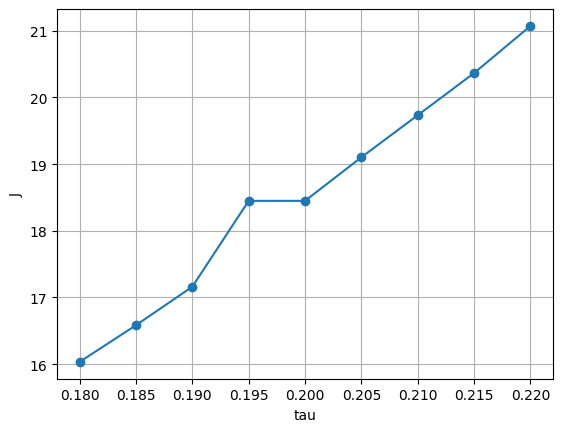

In [ ]:
plt.plot(tau_list,J_true,'-o')
# plt.plot(beta_list,J_esn,'-o')
plt.grid()
plt.xlabel('tau')
plt.ylabel('J')

In [ ]:
def plot_obj_and_grad(p_list, obj_bar, obj_bar_pred, degree):
    coeffs = np.polyfit(p_list, obj_bar, deg = degree)
    vals = np.polyval(coeffs, p_list)

    coeffs_pred = np.polyfit(p_list,obj_bar_pred, deg = degree)
    vals_pred = np.polyval(coeffs_pred, p_list)
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(p_list,obj_bar,'-o',linewidth=2, color='tab:blue')
    plt.plot(p_list,vals,'--',linewidth=2, color='tab:green')
    plt.plot(p_list,obj_bar_pred,'-o',linewidth=2, color='tab:orange')
    plt.plot(p_list,vals_pred,'--',linewidth=2, color='tab:red')
    plt.legend(["True","Approx"])
    plt.title(f"Degree {degree} polynomial approx")
    plt.grid()

    plt.subplot(1,2,2)
    spacing = p_list[1]-p_list[0]
    grads = np.gradient(vals,spacing)
    grads_pred = np.gradient(vals_pred,spacing)
    plt.plot(p_list,grads,'-',linewidth=2, color='tab:blue')
    plt.plot(p_list,grads_pred, '--+', color="tab:orange")
    plt.legend(["True","ESN"])
    plt.grid()
    return coeffs

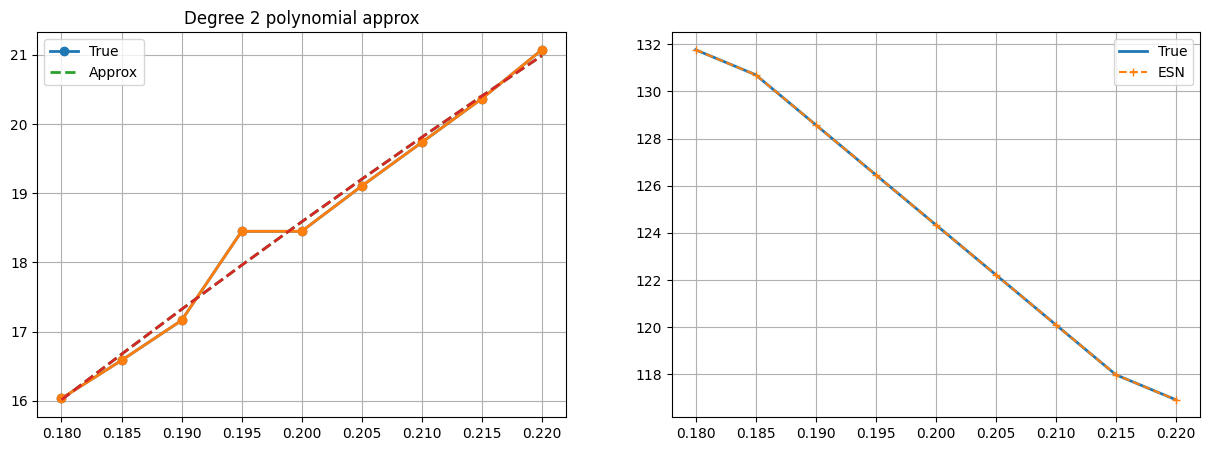

In [ ]:
coeffs = plot_obj_and_grad(tau_list, J_true, J_true, degree=2)

In [ ]:
dcoeffs = np.arange(len(coeffs)-1,0,-1)
np.polyval(dcoeffs*coeffs[:-1],[0.2])

array([124.34102153])

## Sensitivity

In [7]:
from adjoint_esn.utils import postprocessing as post
# generate and train ESN realisations
n_ensemble = 2
ESN_list = [None] * n_ensemble
for e_idx in range(n_ensemble):
    # fix the seeds
    # if n_ensemble == 1:
    #     input_seeds = [20,21,22]
    #     reservoir_seeds = [23,24]
    # else:
    input_seeds = [5 * e_idx, 5 * e_idx + 1, 5 * e_idx + 2]
    reservoir_seeds = [5 * e_idx + 3, 5 * e_idx + 4]
    # expand the ESN dict with the fixed seeds
    ESN_dict["input_seeds"] = input_seeds
    ESN_dict["reservoir_seeds"] = reservoir_seeds

    # create an ESN
    print(f"Creating ESN {e_idx+1}/{n_ensemble}.", flush=True)
    ESN_dict["verbose"] = False
    my_ESN = post.create_ESN(
        ESN_dict, config.model.type, hyp_param_names, hyp_param_scales, hyp_params
    )
    print("Training ESN.")
    my_ESN.train(
        DATA["train"]["u_washout"],
        DATA["train"]["u"],
        DATA["train"]["y"],
        P_washout=DATA["train"]["p_washout"],
        P_train=DATA["train"]["p"],
        train_idx_list=train_idx_list,
    )
    ESN_list[e_idx] = my_ESN


Creating ESN 1/2.
Training ESN.
Creating ESN 2/2.
Training ESN.


In [ ]:
from adjoint_esn.rijke_galerkin import sensitivity as sens
n_loops = 10
test_loop_time_arr = [1.0]
same_washout = True
beta_list = [2.0]
tau_list = [0.2]
eta_1_init = 1.5

p_list = pp.make_param_mesh([beta_list, tau_list])

finite_difference_method = "central"
methods = ["adjoint"]
dJdp = {"true": {}, "esn": {}}
for method_name in methods:
    dJdp["true"][method_name] = np.zeros(
        (len(p_list), 2, n_loops, len(test_loop_time_arr))
    )
    if config.model.type == "standard":
        dJdp["esn"][method_name] = np.zeros(
            (
                n_ensemble,
                len(p_list),
                len(param_vars),
                n_loops,
                len(test_loop_time_arr),
            )
        )
    elif config.model.type == "rijke":
        dJdp["esn"][method_name] = np.zeros(
            (n_ensemble, len(p_list), 2, n_loops, len(test_loop_time_arr))
        )

J = {
    "true": np.zeros((len(p_list), n_loops, len(test_loop_time_arr))),
    "esn": np.zeros((n_ensemble, len(p_list), n_loops, len(test_loop_time_arr))),
}

test_transient_time = config.simulation.transient_time
# when running with same_washout=True, loops start after the washout
# when running with same_washout=False, loops start after the transient
# that's why the initial condition of the first loop changes
if same_washout:
    test_washout_time = config.model.washout_time
else:
    test_washout_time = 0

for p_idx, p in enumerate(p_list):
    p_sim = {"beta": p[eParam.beta], "tau": p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    print("Regime:", regime_str)

    test_sim_time = (
        max(test_loop_time_arr) + test_transient_time + test_washout_time
    )
    test_loop_times = [max(test_loop_time_arr)]

    # set up the initial conditions
    y0 = np.zeros((1, DATA["train"]["u_washout"][0].shape[1]))
    y0[0, 0] = eta_1_init
    u_washout_auto = np.repeat(y0, [len(DATA["train"]["u_washout"][0])], axis=0)

    y0_sim = np.zeros(2 * N_g + 10)
    y0_sim[0] = eta_1_init

    y_sim, t_sim = pp.load_data(
        beta=p_sim["beta"],
        tau=p_sim["tau"],
        x_f=0.2,
        N_g=N_g,
        sim_time=test_sim_time,
        sim_dt=sim_dt,
        data_dir=data_dir,
        integrator=integrator,
        y_init=y0_sim,
    )

    data = pp.create_dataset(
        y_sim,
        t_sim,
        p_sim,
        network_dt=network_dt,
        transient_time=test_transient_time,
        washout_time=test_washout_time,
        loop_times=test_loop_times,
        input_vars=input_vars,
        output_vars=output_vars,
        param_vars=param_vars,
        N_g=N_g,
        u_f_order=u_f_order,
        tau=p_sim["tau"],
    )

    my_rijke = Rijke(
        N_g=N_g,
        N_c=10,
        c_1=0.1,
        c_2=0.06,
        beta=p_sim["beta"],
        x_f=0.2,
        tau=p_sim["tau"],
        heat_law="kings_poly",
        damping="modal",
    )
    print("Running true.", flush=True)
    for loop_time_idx, test_loop_time in enumerate(test_loop_time_arr):
        print("Loop time:", test_loop_time)
        N_transient_ = pp.get_steps(test_transient_time, sim_dt)
        N_washout_ = pp.get_steps(test_washout_time, sim_dt)
        y_init_prev = y_sim[N_transient_ + N_washout_]
        for loop_idx in range(n_loops):
            if loop_idx % 1 == 0:
                print(f"Loop {loop_idx}")
                y_bar, t_bar = pp.load_data(
                    beta=p_sim["beta"],
                    tau=p_sim["tau"],
                    x_f=0.2,
                    N_g=N_g,
                    sim_time=test_loop_time,
                    sim_dt=sim_dt,
                    data_dir=data_dir,
                    integrator=integrator,
                    y_init=y_init_prev,
                )
            # print(y_bar[0])
            y_init_prev = y_bar[-1]
            for method_name in methods:
                if method_name == "direct":
                    dJdp["true"][method_name][
                        p_idx, :, loop_idx, loop_time_idx
                    ] = sens.true_direct_sensitivity(
                        my_rijke, t_bar, y_bar, integrator
                    )
                elif method_name == "adjoint":
                    dJdp["true"][method_name][
                        p_idx, :, loop_idx, loop_time_idx
                    ] = sens.true_adjoint_sensitivity(
                        my_rijke, t_bar, y_bar, integrator
                    )
                elif method_name == "numerical":
                    dJdp["true"][method_name][
                        p_idx, :, loop_idx, loop_time_idx
                    ] = sens.true_finite_difference_sensitivity(
                        my_rijke,
                        t_bar,
                        y_bar,
                        h=1e-5,
                        h_tau=network_dt,
                        method=finite_difference_method,
                        integrator=integrator,
                    )
                print(
                    f'True dJ/dp, {method_name} = {dJdp["true"][method_name][p_idx, :, loop_idx, loop_time_idx]}',
                    flush=True,
                )

            J["true"][p_idx, loop_idx, loop_time_idx] = sens.acoustic_energy(
                y_bar[1:, :], N_g
            )
            print(
                f'True J = {J["true"][p_idx, loop_idx, loop_time_idx]}', flush=True
            )

    for esn_idx in range(n_ensemble):
        my_ESN = ESN_list[esn_idx]
        # Wash-out phase to get rid of the effects of reservoir states initialised as zero
        # initialise the reservoir states before washout
        N = len(data["loop_0"]["u"])
        x0_washout = np.zeros(my_ESN.N_reservoir)
        N_transient_test = pp.get_steps(test_transient_time, network_dt)

        my_ESN.tau = p_sim["tau"]
        # let the ESN run in open-loop for the wash-out
        # get the initial reservoir to start the actual open/closed-loop,
        # which is the last reservoir state
        if same_washout == True:
            X_tau_0 = my_ESN.open_loop(
                x0=x0_washout,
                U=data["loop_0"]["u_washout"],
                P=data["loop_0"]["p_washout"],
            )
            X_tau_1 = X_tau_0[-my_ESN.N_tau - 1 :]
            P_new = np.vstack(
                (
                    data["loop_0"]["p_washout"][-my_ESN.N_tau - 1 :, :],
                    data["loop_0"]["p"],
                )
            )
            X_pred, Y_pred = my_ESN.closed_loop(X_tau_1, N_t=N, P=P_new)
        else:
            # let evolve for a longer time and then remove washout
            N_transient_test = pp.get_steps(
                test_transient_time, config.model.network_dt
            )
            N_washout = pp.get_steps(
                config.model.washout_time, config.model.network_dt
            )
            N_long = N_transient_test + N

            P_washout = data["loop_0"]["p"][0] * np.ones((N_washout, 1))
            P_long = data["loop_0"]["p"][0] * np.ones((N_long, 1))
            X_pred, Y_pred = my_ESN.closed_loop_with_washout(
                U_washout=u_washout_auto,
                N_t=N_long,
                P_washout=P_washout,
                P=P_long,
            )

            # remove transient
            X_tau_1 = X_pred[
                N_transient_test - my_ESN.N_tau - 1 : N_transient_test, :
            ]
            # X_tau_1 = X_pred[: N_transient_test, :]
            X_pred = X_pred[N_transient_test:, :]
            Y_pred = Y_pred[N_transient_test:, :]

        for loop_time_idx, test_loop_time in enumerate(test_loop_time_arr):
            X_tau = X_tau_1 # reset X_tau 
            print("Loop time:", test_loop_time, flush=True)
            N_loop = pp.get_steps(test_loop_time, config.model.network_dt)
            p_loop = data["loop_0"]["p"][0] * np.ones((N_loop + my_ESN.N_tau + 1, 1))

            for loop_idx in range(n_loops):
                if loop_idx % 1 == 0:
                    print(f"Loop {loop_idx}", flush=True)
                # split the prediction data
                x_pred_loop, y_pred_loop = my_ESN.closed_loop(
                    X_tau, N_t=N_loop, P=p_loop
                )
                for method_name in methods:
                    if method_name == "direct":
                        dJdp["esn"][method_name][
                            esn_idx, p_idx, :, loop_idx, loop_time_idx
                        ] = my_ESN.direct_sensitivity(
                            x_pred_loop, y_pred_loop, N_loop, X_tau
                        )
                    elif method_name == "adjoint":
                        dJdp["esn"][method_name][
                            esn_idx, p_idx, :, loop_idx, loop_time_idx
                        ] = my_ESN.adjoint_sensitivity(
                            x_pred_loop, y_pred_loop, N_loop, X_tau, fast_jac=True
                        )
                    elif method_name == "numerical":
                        dJdp["esn"][method_name][
                            esn_idx, p_idx, :, loop_idx, loop_time_idx
                        ] = my_ESN.finite_difference_sensitivity(
                            X=x_pred_loop,
                            Y=y_pred_loop,
                            P=p_loop,
                            N=N_loop,
                            X_tau=X_tau_0,
                            method=finite_difference_method,
                        )
                    print(
                        f'ESN {esn_idx} dJ/dp, {method_name} = {dJdp["esn"][method_name][esn_idx,p_idx,:,loop_idx, loop_time_idx]}',
                        flush=True,
                    )
                X_tau = x_pred_loop[-my_ESN.N_tau - 1 :]

                J["esn"][
                    esn_idx, p_idx, loop_idx, loop_time_idx
                ] = sens.acoustic_energy(y_pred_loop[1:], N_g)
                print(
                    f'ESN {esn_idx} J = {J["esn"][esn_idx, p_idx, loop_idx, loop_time_idx]}'
                ) 

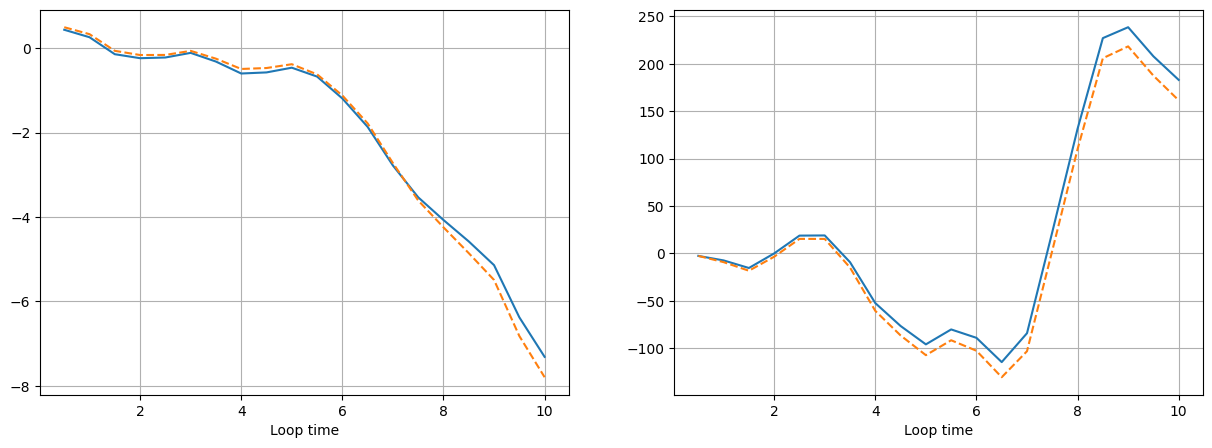

In [ ]:
for loop_idx in range(n_loops):
    fig1 = plt.figure(figsize=(15,5))
    for i, param in enumerate(["beta","tau"]):
        plt.subplot(1,2,i+1)
        plt.plot(test_loop_time_arr, dJdp["true"]["adjoint"][0,eParam[param],loop_idx,:])
        plt.plot(test_loop_time_arr, dJdp["esn"]["adjoint"][0,0,eParam[param],loop_idx,:],'--')
        plt.grid()
        plt.xlabel('Loop time')

In [ ]:
# on yael
res1 = pp.unpickle_file(experiment_path/'sensitivity_results_20240327_004501.pickle')[0]
res2 = pp.unpickle_file(experiment_path/'sensitivity_results_20240327_041125.pickle')[0]
res3 = pp.unpickle_file(experiment_path/'sensitivity_results_20240327_043046.pickle')[0]
res4 = pp.unpickle_file(experiment_path/'sensitivity_results_20240327_043850.pickle')[0]

# on hpc
# res1 = pp.unpickle_file(experiment_path/'sensitivity_results_20240327_145842.pickle')[0]
# res2 = pp.unpickle_file(experiment_path/'sensitivity_results_20240327_150010.pickle')[0]
# res3 = pp.unpickle_file(experiment_path/'sensitivity_results_20240327_153835.pickle')[0]
# res4 = pp.unpickle_file(experiment_path/'sensitivity_results_20240327_154004.pickle')[0]

# res = pp.unpickle_file(experiment_path/'sensitivity_results_20240325_235410.pickle')[0]

res_list = [res1,res2,res3,res4]
for res in res_list:
    fig1 = plt.figure(figsize=(15,5))
    idxs = np.where(res["loop_times"] < 20.0)[0]
    esn_idx = 4
    for i, param in enumerate(["beta","tau"]):
        plt.subplot(1,2,i+1)
        plt.plot(res["loop_times"][idxs]/8.5, res["dJdp"]["true"]["adjoint"][0,eParam[param],0,idxs])
        plt.plot(res["loop_times"][idxs]/8.5, res["dJdp"]["esn"]["adjoint"][esn_idx,0,eParam[param],0,idxs],'--')
        plt.grid()
        plt.xlabel('Integration time [LT]')
        plt.ylabel(f'dJ/d{param}')
        plt.legend(['True','ESN'])


 ## Optimization

In [ ]:
energy_dict = pp.unpickle_file('../data/energy2.pickle')[0]

Text(0, 0.5, 'tau')

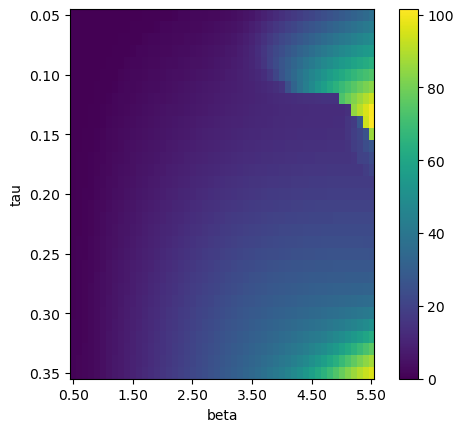

In [ ]:
plt.imshow(energy_dict["J"].T,aspect=2)
plt.colorbar()

xticks = np.arange(0,len(energy_dict["beta_list"]),10)
xtick_idx = [int(xtick) for xtick in xticks]
xticklabels = energy_dict["beta_list"][xtick_idx]
xticklabels = [f"{xticklabel:.2f}" for xticklabel in xticklabels]
yticks = np.arange(0,len(energy_dict["tau_list"]),5)
ytick_idx = [int(ytick) for ytick in yticks]
yticklabels = energy_dict["tau_list"][ytick_idx]
yticklabels = [f"{yticklabel:.2f}" for yticklabel in yticklabels]

plt.xticks(xticks,labels=xticklabels)
plt.yticks(yticks,labels=yticklabels)

plt.xlabel('beta')
plt.ylabel('tau')

In [ ]:
sim_time = transient_time + washout_time
loop_times = [0]
N = 1000

def J_and_dJdp(p, grad = False):
    global iter
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    iter +=1
    print(f'Iteration: {iter}, Regime: {regime_str}')
    
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    loop_name = list(data.keys())[0]

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p[eParam.tau]

    # Wash-out phase to get rid of the effects of reservoir states initialised as zero
    # initialise the reservoir states before washout
    x0_washout = np.zeros(my_ESN.N_reservoir)

    # let the ESN run in open-loop for the wash-out
    # get the initial reservoir to start the actual open/closed-loop,
    # which is the last reservoir state
    X_tau = my_ESN.open_loop(x0=x0_washout, U=data[loop_name]["u_washout"], P=data[loop_name]["p_washout"])
    P_grad = data[loop_name]["p_washout"][0]*np.ones((N,1))
    P_grad = np.vstack((data[loop_name]["p_washout"][-my_ESN.N_tau - 1 :, :], P_grad))
    X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N, P=P_grad)
    J = acoustic_energy(Y_pred_grad[1:,:], N_g)
    if not grad:
        print(f'J = {J}')
        return J
    else:
        dJdp=my_ESN.finite_difference_sensitivity(X_pred_grad, 
                                                Y_pred_grad, 
                                                X_tau, 
                                                P_grad, 
                                                N)
        # dJdp=my_ESN.adjoint_sensitivity(X_pred_grad, 
        #                                 Y_pred_grad, 
        #                                 N,
        #                                 X_tau)
        print(f'J = {J}, dJdp = {dJdp}')
        return J, dJdp

In [ ]:
y0 = np.zeros((1,DATA["train"]["u_washout"][0].shape[1]))
eta_1_init = 1.5
y0[0,0] = eta_1_init
u_washout_auto = np.repeat(y0, [len(DATA["train"]["u_washout"][0])], axis = 0)

In [ ]:
N = 10000
transient_steps = pp.get_steps(transient_time, network_dt)
# add the transient time that will be discarded later
N_long = transient_steps + N
def get_dJdp(p):
    global iter
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    iter +=1
    print(f'Iteration: {iter}, Regime: {regime_str}')

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p[eParam.tau]

    # Wash-out phase to get rid of the effects of reservoir states initialised as zero
    # initialise the reservoir states before washout
    x0_washout = np.zeros(my_ESN.N_reservoir)

    # let the ESN run in open-loop for the wash-out
    # get the initial reservoir to start the actual open/closed-loop,
    # which is the last reservoir state
    p_washout = p_sim["beta"]*np.ones((u_washout_auto.shape[0],1))
    X_tau = my_ESN.open_loop(x0=x0_washout, U=u_washout_auto, P=p_washout)
    P_grad = p_washout[0]*np.ones((N_long,1))
    P_grad = np.vstack((p_washout[-my_ESN.N_tau - 1 :, :], P_grad))
    X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N_long, P=P_grad)
    
    # remove transient
    X_tau = X_pred_grad[:transient_steps,:]
    X_pred_grad = X_pred_grad[transient_steps:,:]
    Y_pred_grad = Y_pred_grad[transient_steps:,:]
    P_grad = P_grad[transient_steps:,:]
    
    J = acoustic_energy(Y_pred_grad[1:,:], N_g)
    dJdp=my_ESN.finite_difference_sensitivity(X_pred_grad, 
                                            Y_pred_grad, 
                                            X_tau, 
                                            P_grad, 
                                            N)
    
    # dJdp=my_ESN.adjoint_sensitivity(X_pred_grad, 
    #                                 Y_pred_grad, 
    #                                 N,
    #                                 X_tau)
    print(f'J = {J}, dJdp = {dJdp}')
    return dJdp

In [ ]:
from scipy.optimize import minimize
from functools import partial 
# Optimize using gradient information
p0 = [None]*2
p0[eParam.beta] = 5.0
p0[eParam.tau] = 0.2
bounds = ((0.5,5.5),(0.05,0.35))
global iter
iter = 0
opt = minimize(get_dJdp, p0, method='L-BFGS-B', bounds=bounds, jac=True)

In [ ]:
def gradient_descent(start,
                     norm,
                     gradient, 
                     learn_rate, 
                     bounds = None,
                     max_iter = 100, 
                     tol = 0.001):
    x = start
    steps = [start]  # history tracking
    
    x_hat = start/norm
    for _ in range(max_iter):
        grad_hat = norm*gradient(x)

        print(f"beta_hat: {x_hat[0]}, tau_hat = {x_hat[1]}")
        print(f"dJ/dbeta_hat: {grad_hat[0]}, dJ/dtau = {grad_hat[1]}")

        diff = learn_rate*grad_hat

        if np.linalg.norm(diff) < tol:
            break

        x_hat = x_hat - diff

        x = norm*x_hat
        
        # round tau
        x[1] = np.round(x[1], 2)
                        
        # check the bounds
        if bounds:
            x = np.array([max(x[i], bounds[i][0]) for i in range(len(x))])
            x = np.array([min(x[i], bounds[i][1]) for i in range(len(x))])
        
        steps.append(x)  # history tracing

        # if np.linalg.norm(x-x_prev) < tol:
        #     learn_rate = 10*learn_rate

        # x_prev = x
    return steps, x

In [ ]:
def adam(start,
        gradient, 
        learn_rate, 
        bounds = None,
        max_iter = 100, 
        tol = 0.001):
    
    x = start
    steps = [start]  # history tracking
    alpha = learn_rate

    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-8

    m_t = 0
    v_t = 0
    
    for t in np.arange(1, max_iter+1):
        g_t = gradient(x)
        m_t = beta_1*m_t + (1-beta_1)*g_t
        v_t = beta_2*v_t + (1-beta_2)*g_t**2
        m_t_hat = m_t / (1-beta_1**t)
        v_t_hat = v_t / (1-beta_2**t)

        diff = alpha * m_t_hat/np.sqrt(v_t_hat+epsilon)

        if np.linalg.norm(diff) < tol:
            break

        x = x - diff
        
        # round tau
        x[1] = np.round(x[1], 2)
                        
        # check the bounds
        if bounds:
            x = [max(x[i], bounds[i][0]) for i in range(len(x))]
            x = [min(x[i], bounds[i][1]) for i in range(len(x))]
        
        steps.append(x)  # history tracing
  
    return steps, x

In [ ]:
p0 = [None]*2
p0[eParam.beta] = 4.0
p0[eParam.tau] = 0.25
global iter
iter = 0

opt = gradient_descent(start = np.array(p0),
                       gradient=get_dJdp, 
                       norm = np.array([3.0,0.2]),
                       bounds = ((0.5,5.5),
                                 (0.05,0.35)),
                       learn_rate=np.array([0.01,0.01]),
                       max_iter=10)

Iteration: 1, Regime: beta = 4.0, tau = 0.25
J = 24.148849838368385, dJdp = [  3.25962028 129.57521843]
beta_hat: 1.3333333333333333, tau_hat = 1.25
dJ/dbeta_hat: 9.778860830422785, dJ/dtau = 25.915043685933735
Iteration: 2, Regime: beta = 3.7066341750873164, tau = 0.2
J = 16.75136115462608, dJdp = [  2.9376096 111.4004218]
beta_hat: 1.2355447250291054, tau_hat = 0.9908495631406626
dJ/dbeta_hat: 8.812828800586201, dJ/dtau = 22.280084359100876
Iteration: 3, Regime: beta = 3.4422493110697303, tau = 0.15
J = 11.28893750258266, dJdp = [ 2.85321262 62.51620796]
beta_hat: 1.1474164370232434, tau_hat = 0.7680487195496539
dJ/dbeta_hat: 8.559637845451105, dJ/dtau = 12.50324159185654
Iteration: 4, Regime: beta = 3.185460175706197, tau = 0.13
J = 9.326295965406784, dJdp = [ 3.43943957 45.69891423]
beta_hat: 1.0618200585687323, tau_hat = 0.6430163036310885
dJ/dbeta_hat: 10.318318716517892, dJ/dtau = 9.13978284561141
Iteration: 5, Regime: beta = 2.8759106142106603, tau = 0.11
J = 7.078397748497562,

In [ ]:
p0 = [None]*2
p0[eParam.beta] = 4.0
p0[eParam.tau] = 0.2
global iter
iter = 0
opt = adam(start = p0,
                gradient=get_dJdp, 
                bounds = ((0.5,5.5),
                            (0.05,0.35)),
                learn_rate=[0.1])

In [ ]:
N = 10000
transient_steps = pp.get_steps(transient_time, network_dt)
# add the transient time that will be discarded later
N_long = transient_steps + N

def get_J_dJdp_1(p):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    loop_name = list(data.keys())[0]

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p[eParam.tau]

    # Wash-out phase to get rid of the effects of reservoir states initialised as zero
    # initialise the reservoir states before washout
    x0_washout = np.zeros(my_ESN.N_reservoir)

    # let the ESN run in open-loop for the wash-out
    # get the initial reservoir to start the actual open/closed-loop,
    # which is the last reservoir state
    X_tau = my_ESN.open_loop(x0=x0_washout, U=data[loop_name]["u_washout"], P=data[loop_name]["p_washout"])
    P_grad = data[loop_name]["p_washout"][0]*np.ones((N,1))
    P_grad = np.vstack((data[loop_name]["p_washout"][-my_ESN.N_tau - 1 :, :], P_grad))
    X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N, P=P_grad)
    J = acoustic_energy(Y_pred_grad[1:,:], N_g)

    dJdp=my_ESN.finite_difference_sensitivity(X_pred_grad, 
                                            Y_pred_grad, 
                                            X_tau, 
                                            P_grad, 
                                            N)
    return J, dJdp

def get_J_dJdp_2(p):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p[eParam.tau]

    # Wash-out phase to get rid of the effects of reservoir states initialised as zero
    # initialise the reservoir states before washout
    x0_washout = np.zeros(my_ESN.N_reservoir)

    # let the ESN run in open-loop for the wash-out
    # get the initial reservoir to start the actual open/closed-loop,
    # which is the last reservoir state
    p_washout = p_sim["beta"]*np.ones((u_washout_auto.shape[0],1))
    X_tau = my_ESN.open_loop(x0=x0_washout, U=u_washout_auto, P=p_washout)
    P_grad = p_washout[0]*np.ones((N_long,1))
    P_grad = np.vstack((p_washout[-my_ESN.N_tau - 1 :, :], P_grad))
    X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N_long, P=P_grad)
    
    # remove transient
    X_tau = X_pred_grad[:transient_steps,:]
    X_pred_grad = X_pred_grad[transient_steps:,:]
    Y_pred_grad = Y_pred_grad[transient_steps:,:]
    P_grad = P_grad[transient_steps:,:]
    
    J = acoustic_energy(Y_pred_grad[1:,:], N_g)

    dJdp=my_ESN.finite_difference_sensitivity(X_pred_grad, 
                                            Y_pred_grad, 
                                            X_tau, 
                                            P_grad, 
                                            N)
    return J, dJdp


In [ ]:
p0 = [None]*2
p0[eParam.beta] = 5.0
p0[eParam.tau] = 0.2

print(get_J_dJdp_1(p0))
print(get_J_dJdp_2(p0))

(18.804644157245296, array([  0.36899984, 125.32292556]))
(18.811399344482673, array([  0.37842972, 124.56308985]))


In [ ]:
res = pp.unpickle_file(experiment_path/"optimization_results_20231115_110034.pickle")[0]

## comparison sensitivity noisy sensitivity

In [ ]:
res_clean = pp.unpickle_file(experiment_path/"sensitivity_results_20231113_125101.pickle")[0]
res_noisy1 = pp.unpickle_file(experiment_path/"sensitivity_results_20240229_065345.pickle")[0]
res_noisy5 = pp.unpickle_file(experiment_path/"sensitivity_results_20240229_063232.pickle")[0]
res_tikh5 = pp.unpickle_file(experiment_path/"sensitivity_results_20240305_055442.pickle")[0]
res_tikh3 = pp.unpickle_file(experiment_path/"sensitivity_results_20240305_070726.pickle")[0]
res_tikh4 = pp.unpickle_file(experiment_path/"sensitivity_results_20240305_075147.pickle")[0]
res_tikh2 = pp.unpickle_file(experiment_path/"sensitivity_results_20240305_234046.pickle")[0]

In [ ]:
def get_mean_std(res):
    dJdp_mean = np.mean(res["dJdp"]["esn"]["adjoint"], axis=0)
    dJdp_std = np.std(res["dJdp"]["esn"]["adjoint"], axis=0)
    p_list = pp.make_param_mesh([res["beta_list"], res["tau_list"]])
    return dJdp_mean, dJdp_std, p_list

1e-05
0.0001
0.001
0.01


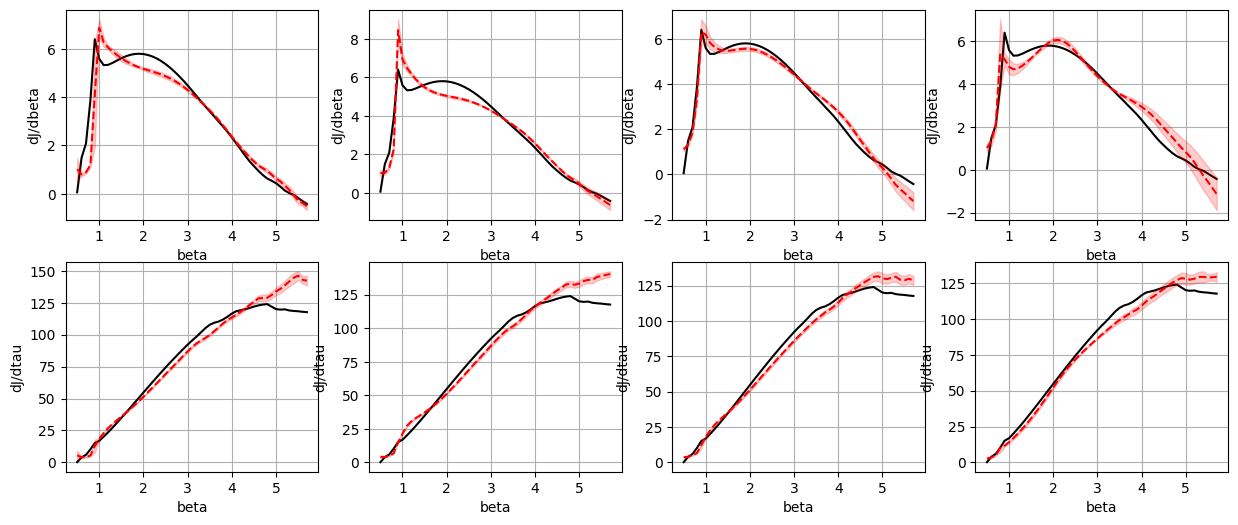

In [ ]:
plt.figure(figsize=(15,6))
dJdp_mean = [None]*4
dJdp_std = [None]*4
res_list = [res_tikh5,res_tikh4,res_tikh3,res_tikh2]
for i, res in enumerate(res_list):
    dJdp_mean1, dJdp_std1, p_list = get_mean_std(res)
    dJdp_mean[i] = dJdp_mean1
    dJdp_std[i] = dJdp_std1
    print(res["tikhonov"])
for m in range(4):
    for i in range(2):
        plt.subplot(2,4,4*i+m+1)
        vis.plot_lines(
            p_list[:, 0],
            res_clean["dJdp"]["true"]["adjoint"][:, i],
            dJdp_mean[m][:,i],
            color=['k','red'],
            linestyle=['-','--']
        )

        plt.fill_between(
            p_list[:, 0],
            dJdp_mean[m][:, i] - dJdp_std[m][:, i],
            dJdp_mean[m][:, i] + dJdp_std[m][:, i],
            alpha=0.2,
            antialiased=True,
            zorder=2,
            color='red'
        )

        plt.grid(visible=True)
        plt.xlabel('beta')
        if i == 0:
            plt.ylabel('dJ/dbeta')
        elif i == 1:
            plt.ylabel('dJ/dtau')

## chaotic sensitivity

0.9339166120756064
0.7347059860910283
-1.9409898795334002
-1.3895017493933361


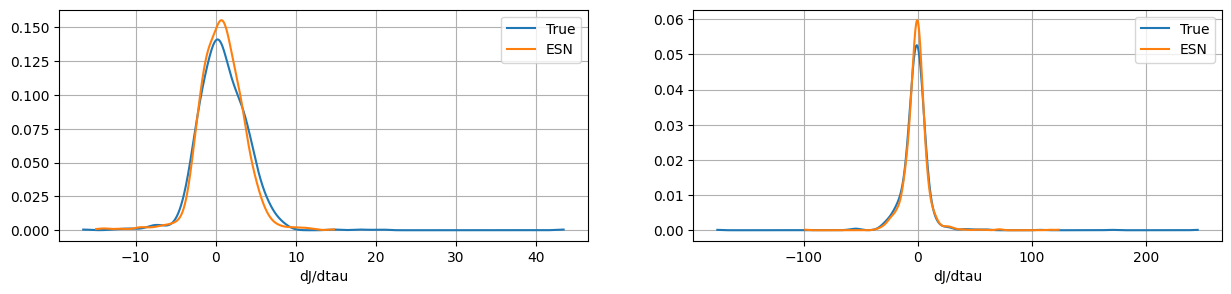

In [ ]:
experiment_path=Path('../local_results/rijke/run_20240307_175258')
# beta = 7.2, tau = 0.2
# res_list = ['20240318_221306',
#             '20240318_231210',
#             '20240319_030447'
#             ] 
# beta = 7.6, tau = 0.22
res_list = [#'20240319_225725', #2
            # '20240320_002917', #4
            # '20240320_024806', #8
            # "20240321_001405"  #16
            ] 
# res_list = ['20240323_071655',
#             '20240323_042211']
res_list = ['20240327_034611',
            '20240327_104027'
            ]
# beta = 8.25, tau = 0.23
# res_list = ['20240320_133120',
#             '20240320_151917',
#             '20240320_163818',
#             ] 

# beta = 8.7, tau = 0.23
# res_list = ['20240322_000539',
#             '20240322_011736',
#             '20240322_164137',
#             '20240322_034858',
#             '20240322_061403',
#             '20240322_222107'
#             ] 
# res_list = ['20240324_131328',
#             '20240324_173401',
#             '20240324_233647',
#             '20240324_175007',
#             '20240325_062533']
# experiment_path=Path('../local_results/rijke/run_20231029_153121') # no noise
# beta = 7.2, tau = 0.2
# res_list = ['20240319_015922',
#             '20240319_030319',
#             '20240319_060146'
#             ] 
# beta = 7.6, tau = 0.22
# res_list = ['20240320_001208',
#             '20240320_014719',
#             '20240320_042653'
#             ] 

var_idx = 0
esn_idx = 0
plt.figure(figsize=(15,3))
for i, res_name in enumerate(res_list):
    res = pp.unpickle_file(experiment_path/f'sensitivity_results_{res_name}.pickle')[0]

    dJdp_true = res["dJdp"]["true"]["adjoint"]
    dJdp_esn = res["dJdp"]["esn"]["adjoint"]

    n_loops = dJdp_true.shape[2]
    dJdp_true_mean = 1/np.arange(1,n_loops+1) * np.cumsum(dJdp_true[0,var_idx,:,0])
    dJdp_esn_mean = 1/np.arange(1,n_loops+1) * np.cumsum(dJdp_esn[esn_idx,0,var_idx,:,0])

    print(dJdp_true_mean[-1])
    print(dJdp_esn_mean[-1])

    plt.subplot(1,len(res_list),i+1)
    # plt.plot(dJdp_true_mean)
    # plt.plot(dJdp_esn_mean)
    # plt.grid()
    # plt.title(f'Time: {res["loop_times"][0]}')
    vis.plot_statistics(dJdp_true[0,var_idx,:,0],dJdp_esn[esn_idx,0,var_idx,:,0],n_bins=1000)
    # plt.ylim([0.0,0.001])
    # plt.hist(dJdp_true[0,var_idx,:,0],bins=100, density=True)
    # plt.hist(dJdp_esn[0,0,var_idx,:,0],bins=100, density=True)
    # plt.vlines(dJdp_true_mean[-1], ymin=0, ymax=0.002, linestyle='-', color='black')
    # plt.vlines(dJdp_esn_mean[-1], ymin=0, ymax=0.002, linestyle='--', color='grey')
    plt.xlabel('dJ/dtau')
    plt.legend(['True','ESN','True mean','ESN mean'])
    

In [ ]:
dJdp_true[0,:,1,0]

array([  -1.62441441, -105.16813208])

19.769635697542412
19.763985563910804
19.463086560388696
19.665986979131436
19.572538055038542
19.71091770398961
19.434993777321946
19.742254817744275


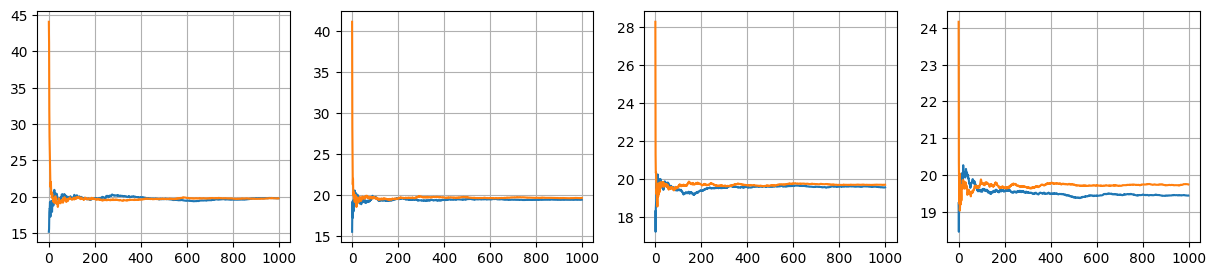

In [ ]:
plt.figure(figsize=(15,3))
for i, res_name in enumerate(res_list):
    res = pp.unpickle_file(experiment_path/f'sensitivity_results_{res_name}.pickle')[0]

    J_true = res["J"]["true"]
    J_esn = res["J"]["esn"]
  
    J_true_mean = 1/np.arange(1,1001) * np.cumsum(J_true[0,:,0])
    J_esn_mean = 1/np.arange(1,1001) * np.cumsum(J_esn[0,0,:,0])
    print(J_true_mean[-1])
    print(J_esn_mean[-1])
    plt.subplot(1,len(res_list),i+1)
    plt.plot(J_true_mean)
    plt.plot(J_esn_mean)
    plt.grid()

Text(0, 0.5, 'tau')

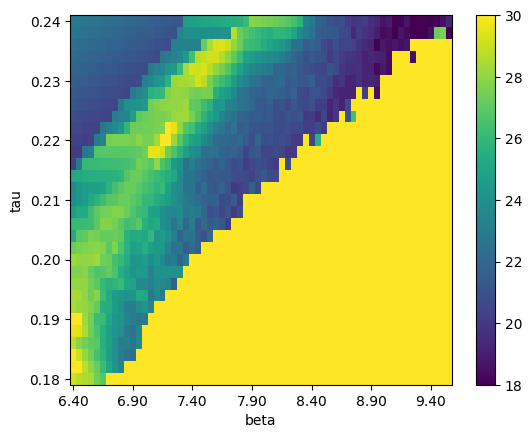

In [ ]:
energy_dict = pp.unpickle_file('../data/energy_chaotic.pickle')[0]
plt.imshow(energy_dict["J"].T,aspect=2,origin='lower',vmin=18,vmax=30)
plt.colorbar()

xticks = np.arange(0,len(energy_dict["beta_list"]),10)
xtick_idx = [int(xtick) for xtick in xticks]
xticklabels = energy_dict["beta_list"][xtick_idx]
xticklabels = [f"{xticklabel:.2f}" for xticklabel in xticklabels]
yticks = np.arange(0,len(energy_dict["tau_list"]),5)
ytick_idx = [int(ytick) for ytick in yticks]
yticklabels = energy_dict["tau_list"][ytick_idx]
yticklabels = [f"{yticklabel:.2f}" for yticklabel in yticklabels]

plt.xticks(xticks,labels=xticklabels)
plt.yticks(yticks,labels=yticklabels)

plt.xlabel('beta')
plt.ylabel('tau')

In [ ]:
energy_dict["beta_list"][38]

8.299999999999994

In [ ]:
energy_dict["tau_list"][25]

0.23000000000000004

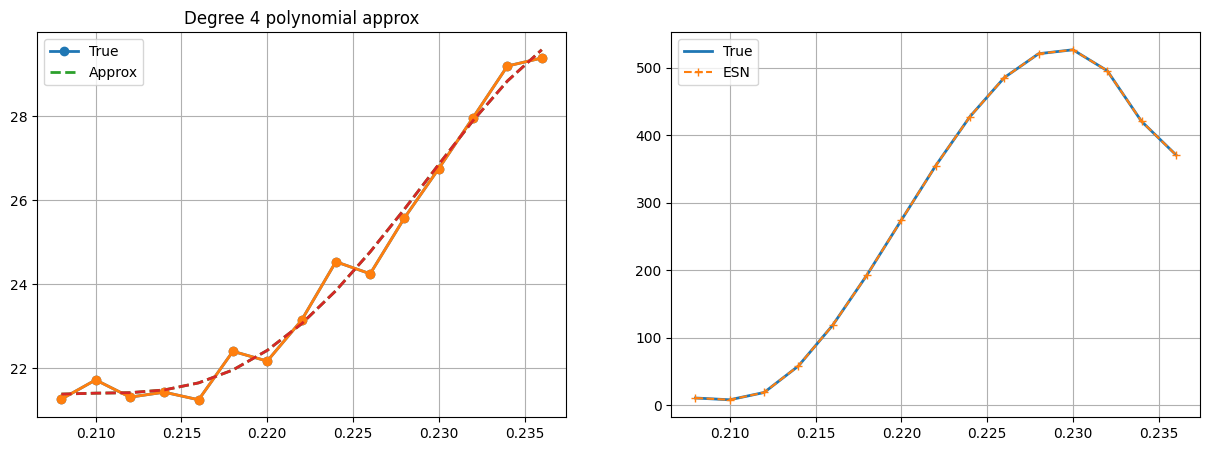

In [ ]:
# beta = 7.6, tau = 0.22
coeffs = plot_obj_and_grad(energy_dict["tau_list"][14:-2], energy_dict["J"][24,14:-2], energy_dict["J"][24,14:-2], degree=4)

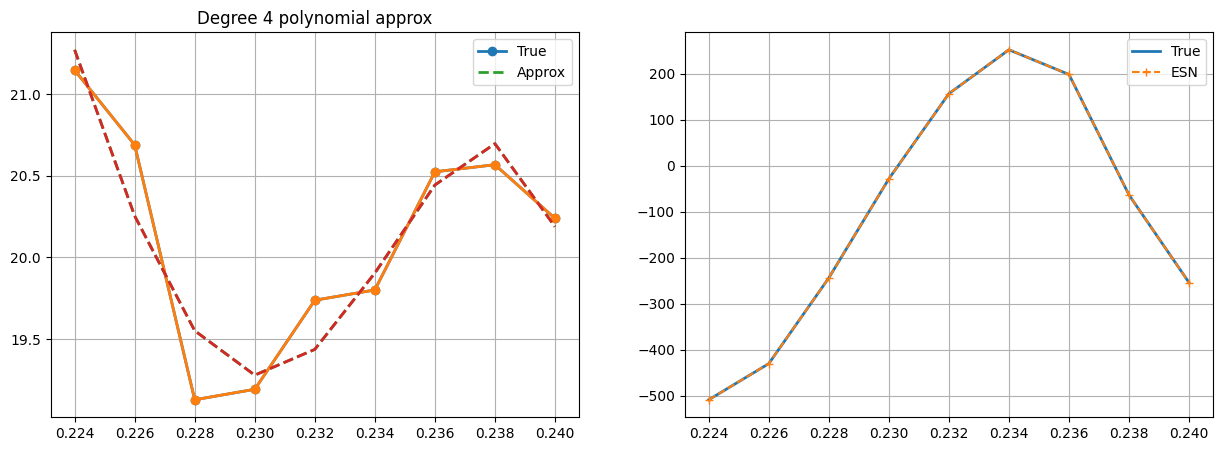

In [ ]:
# beta = 8.7, tau = 0.23
coeffs = plot_obj_and_grad(energy_dict["tau_list"][22:], energy_dict["J"][46,22:], energy_dict["J"][46,22:], degree=4)

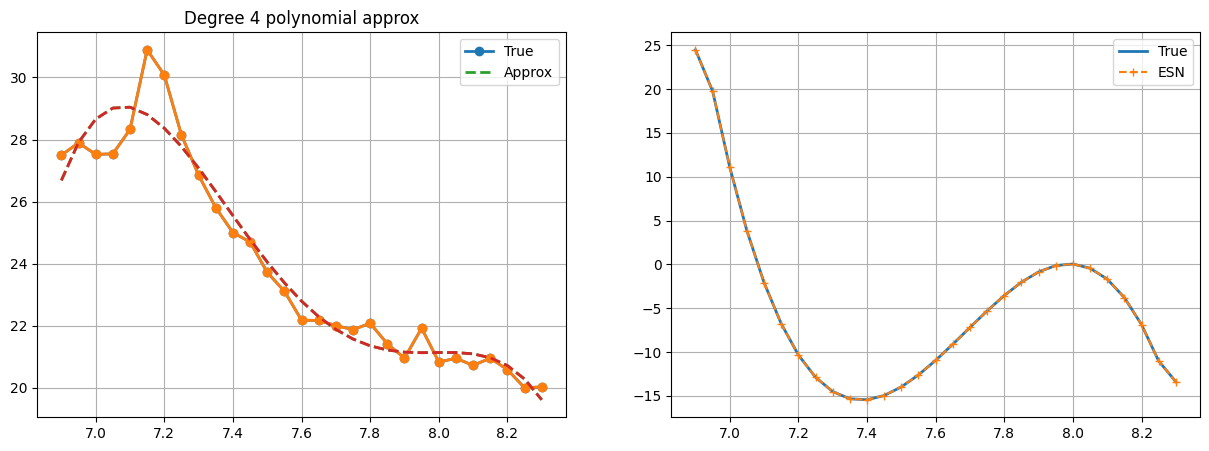

In [ ]:
# beta = 7.6, tau = 0.22
coeffs = plot_obj_and_grad(energy_dict["beta_list"][10:-25], energy_dict["J"][10:-25,20], energy_dict["J"][10:-25,20], degree=4)

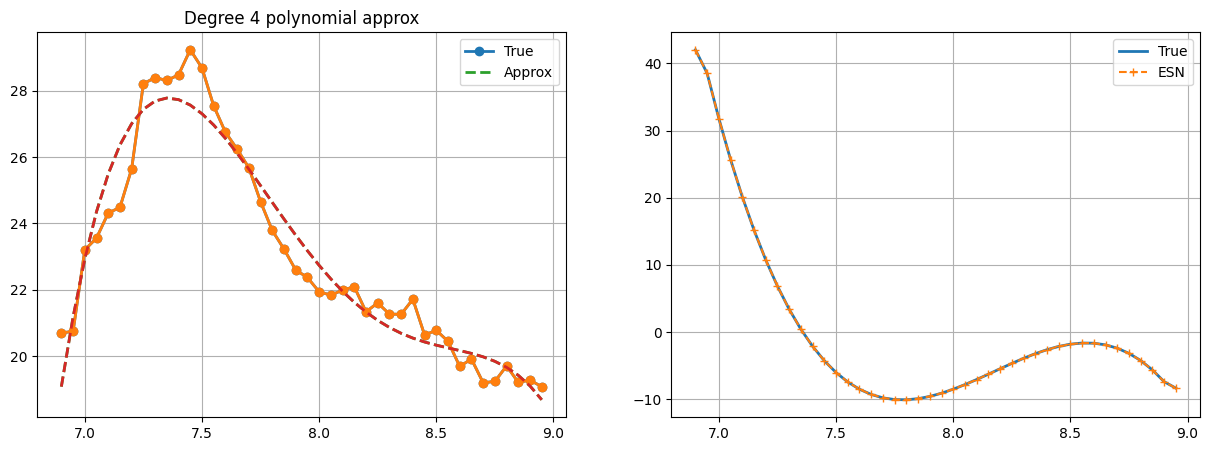

In [ ]:
# beta = 8.7, tau = 0.23
coeffs = plot_obj_and_grad(energy_dict["beta_list"][10:-12], energy_dict["J"][10:-12,25], energy_dict["J"][10:-12,25], degree=4)

In [ ]:
dcoeffs = np.arange(len(coeffs)-1,0,-1)
np.polyval(dcoeffs*coeffs[:-1],[8.7])

array([-2.34742297])

dJdbeta= [-7.34931043]
dJdtau= [94.02784947]


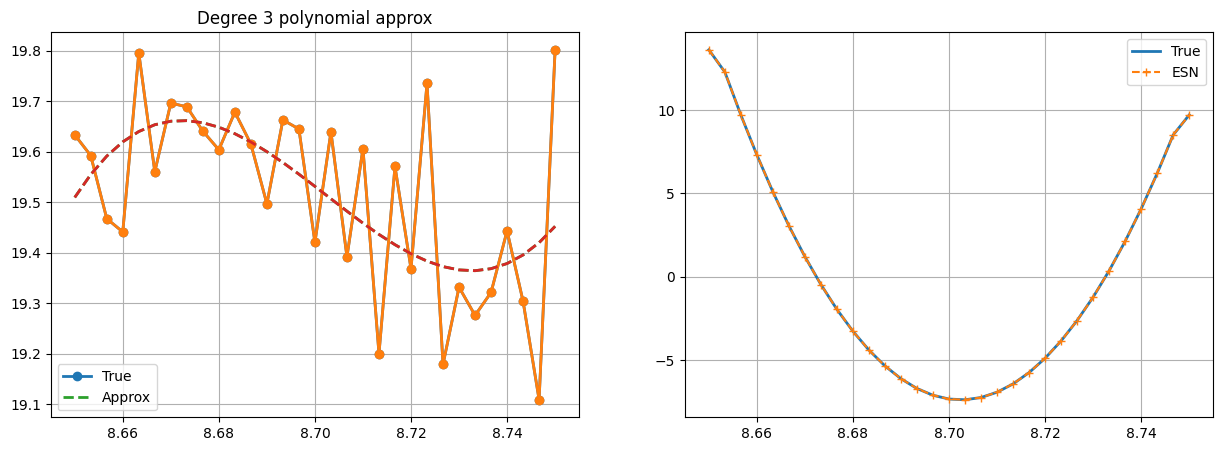

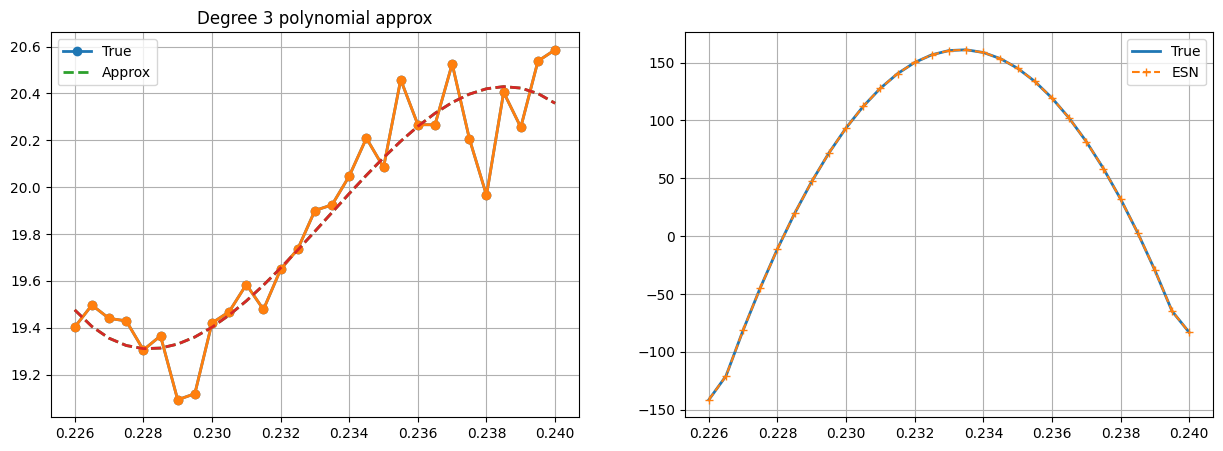

In [ ]:
energy_dict = pp.unpickle_file('../data/energy_beta_8_7_tau_0_23_vary_beta.pickle')[0]
coeffs = plot_obj_and_grad(energy_dict["beta_list"], energy_dict["J"][:,0], energy_dict["J"][:,0], degree=3)
dcoeffs = np.arange(len(coeffs)-1,0,-1)
dJdbeta_approx = np.polyval(dcoeffs*coeffs[:-1],[8.7])
print('dJdbeta=',dJdbeta_approx)

energy_dict = pp.unpickle_file('../data/energy_beta_8_7_tau_0_23_vary_tau.pickle')[0]
coeffs = plot_obj_and_grad(energy_dict["tau_list"][2:], energy_dict["J"][0,2:], energy_dict["J"][0,2:], degree=3)
dcoeffs = np.arange(len(coeffs)-1,0,-1)
dJdtau_approx = np.polyval(dcoeffs*coeffs[:-1],[0.23])
print('dJdtau=',dJdtau_approx)

dJdbeta= [-11.22494739]
dJdtau= [354.23873545]


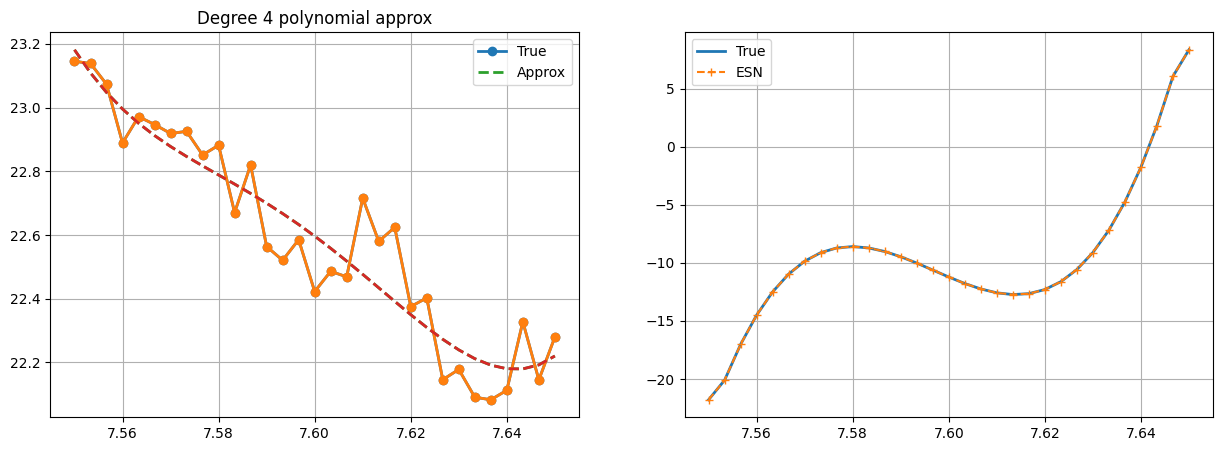

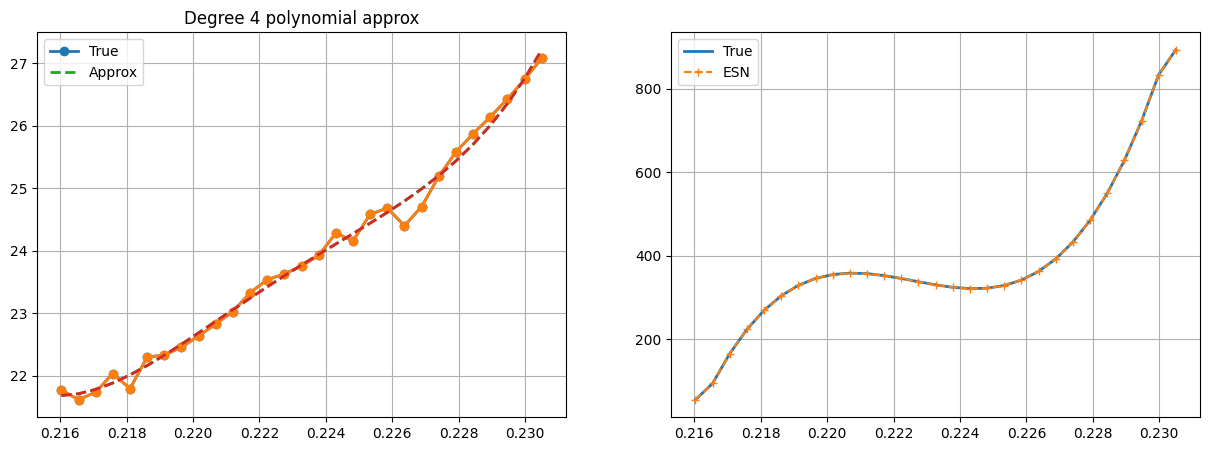

In [ ]:
energy_dict = pp.unpickle_file('../data/energy_beta_7_6_tau_0_22_vary_beta.pickle')[0]
coeffs = plot_obj_and_grad(energy_dict["beta_list"], energy_dict["J"][:,0], energy_dict["J"][:,0], degree=4)
dcoeffs = np.arange(len(coeffs)-1,0,-1)
dJdbeta_approx = np.polyval(dcoeffs*coeffs[:-1],[7.6])
print('dJdbeta=',dJdbeta_approx)

energy_dict = pp.unpickle_file('../data/energy_beta_7_6_tau_0_22_vary_tau.pickle')[0]
coeffs = plot_obj_and_grad(energy_dict["tau_list"][2:], energy_dict["J"][0,2:], energy_dict["J"][0,2:], degree=4)
dcoeffs = np.arange(len(coeffs)-1,0,-1)
dJdtau_approx = np.polyval(dcoeffs*coeffs[:-1],[0.22])
print('dJdtau=',dJdtau_approx)

## sensitivity to initial conditions

In [8]:
from adjoint_esn.rijke_galerkin import sensitivity as sens
data_dir=Path('..\data')
p_sim = {'beta':7.6, 'tau':0.22}
loop_times = [1.0]
N_g = 4
sim_dt = 1e-3
sim_time = transient_time+washout_time+loop_times[0]

my_rijke = Rijke(
            N_g=N_g,
            N_c=10,
            c_1=0.1,
            c_2=0.06,
            beta=p_sim["beta"],
            x_f=0.2,
            tau=p_sim["tau"],
            heat_law="kings_poly",
            damping="modal",
        )

y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                            sim_time=sim_time,sim_dt=sim_dt,
                            data_dir=data_dir, y_init = None)

N_transient_ = pp.get_steps(transient_time, sim_dt)
N_washout_ = pp.get_steps(washout_time, sim_dt)
y_bar = y_sim[N_transient_ + N_washout_:]
t_bar = t_sim[N_transient_ + N_washout_:]
t_bar = t_bar-t_bar[0]

# dJdu0_finite_true = sens.true_finite_difference_sensitivity_init(my_rijke, t_bar, y_bar, h=1e-5, method='central')
# dJdu0_direct_true = sens.true_direct_sensitivity_init(my_rijke, t_bar, y_bar)
dJdu0_adjoint_true = sens.true_adjoint_sensitivity_init(my_rijke, t_bar, y_bar)

# dJdp_finite_true = sens.true_finite_difference_sensitivity(my_rijke, t_bar, y_bar, h=1e-5, h_tau=1e-2, method='central')
# dJdp_direct_true = sens.true_direct_sensitivity(my_rijke, t_bar, y_bar)
# dJdp_adjoint_true = sens.true_adjoint_sensitivity(my_rijke, t_bar, y_bar)

In [7]:
data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        start_idxs=None,
                        noise_level=0.0,
                        random_seed=random_seed,
                        tau=p_sim["tau"])

# predict on the whole timeseries
N = len(data["loop_0"]["u"])
if hasattr(my_ESN,"tau"):
    my_ESN.tau = p_sim["tau"]

x0_washout = np.zeros(my_ESN.N_reservoir)    
X_tau_0 = my_ESN.open_loop(
                x0=x0_washout,
                U=data["loop_0"]["u_washout"],
                P=data["loop_0"]["p_washout"],
            )
X_tau = X_tau_0[-my_ESN.N_tau - 1 :]
P_new = np.vstack(
                (
                    data["loop_0"]["p_washout"][-my_ESN.N_tau - 1 :, :],
                    data["loop_0"]["p"],
                )
            )
X_pred, Y_pred = my_ESN.closed_loop(X_tau=X_tau, 
                                    N_t=N, 
                                    P=P_new)

# dJdx0_finite = my_ESN.finite_difference_sensitivity_x0(X_pred, Y_pred, X_tau_0, P_new, N=N, h=1e-5, method="central")
# dJdx0_direct = my_ESN.direct_sensitivity_x0(X_pred, Y_pred, N, X_tau, fast_jac=True)
dJdx0_adjoint = my_ESN.adjoint_sensitivity_x0(X_pred, Y_pred, N, X_tau, fast_jac=True)

# dJdu0_finite = my_ESN.finite_difference_sensitivity_u0(X_pred, Y_pred, X_tau, P_new, N=N, h=1e-5, method="central")
# dJdu0_direct = my_ESN.direct_sensitivity_u0(X_pred, Y_pred, N,  X_tau, fast_jac=True)
dJdu0_adjoint = my_ESN.adjoint_sensitivity_u0(X_pred, Y_pred, N,  X_tau, fast_jac=True)

# dJdp_finite = my_ESN.finite_difference_sensitivity(X_pred, Y_pred, X_tau_0, P_new, N=N, h=1e-5, method="central")
# dJdp_direct = my_ESN.direct_sensitivity(X_pred, Y_pred, N, X_tau, fast_jac=True)
# dJdp_adjoint = my_ESN.adjoint_sensitivity(X_pred, Y_pred, N, X_tau, fast_jac=True)

# N OR N-1 ??? FIGURE THIS OUT

In [8]:
dJdx0_from_u0 = np.dot(my_ESN.W_out,dJdu0_adjoint_true[:2*N_g])
print('dJ/dx0 ESN:', dJdx0_adjoint)
print('dJ/dx0 from dJ/du0 of true system:', dJdx0_from_u0)

dJdu0_from_x0 = np.dot(np.linalg.pinv(my_ESN.W_out), dJdx0_adjoint)
print('dJ/du0 True', dJdu0_adjoint_true[:2*N_g])
print('dJ/du0 ESN:', dJdu0_adjoint)
print('dJ/du0 from dJ/dx0 of ESN:', dJdu0_from_x0)


dJ/dx0 ESN: [33.41661822 46.07300363  7.12794678 ... 25.52662107  3.41303287
 -3.21352657]
dJ/dx0 from dJ/du0 of true system: [21.8786941  34.33766461  7.32298726 ... 11.27442282  0.82501658
 -2.71796808]
dJ/du0 True [ 5.31478723  0.05768341  0.95621605  2.37596064 -2.73066338  0.53676507
 -3.85912686 -1.42604576]
dJ/du0 ESN: [ 3.55222505  0.04563439  0.67097649  1.73617339 -2.33742388 -0.37312441
 -2.88698395 -1.42572827]
dJ/du0 from dJ/dx0 of ESN: [ 5.62867177  0.20245315  0.87113661  2.14429622 -3.81598699 -0.37556332
 -4.68130838 -2.36824084]


In [32]:
from adjoint_esn.rijke_galerkin import sensitivity as sens
n_loops = 20
test_loop_time_arr = [0.1]
beta_list = [7.6]
tau_list = [0.22]
eta_1_init = 1.0

p_list = pp.make_param_mesh([beta_list, tau_list])

finite_difference_method = "central"
methods = ["adjoint"]
dJdu0 = {"true": {}, "esn": {}, "esn_from_x0": {}}
for method_name in methods:
    dJdu0["true"][method_name] = np.zeros(
        (len(p_list), 2*N_g + 10, n_loops, len(test_loop_time_arr))
    )
    dJdu0["esn"][method_name] = np.zeros(
        (n_ensemble, len(p_list), my_ESN.N_dim, n_loops, len(test_loop_time_arr))
        )
    dJdu0["esn_from_x0"][method_name] = np.zeros(
        (n_ensemble, len(p_list), my_ESN.N_dim, n_loops, len(test_loop_time_arr))
    )

J = {
    "true": np.zeros((len(p_list), n_loops, len(test_loop_time_arr))),
    "esn": np.zeros((n_ensemble, len(p_list), n_loops, len(test_loop_time_arr))),
}

test_transient_time = config.simulation.transient_time
test_washout_time = config.model.washout_time

for p_idx, p in enumerate(p_list):
    p_sim = {"beta": p[eParam.beta], "tau": p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    print("Regime:", regime_str)

    test_sim_time = (
        max(test_loop_time_arr) + test_transient_time + test_washout_time
    )
    test_loop_times = [max(test_loop_time_arr)]

    # set up the initial conditions
    y0 = np.zeros((1, DATA["train"]["u_washout"][0].shape[1]))
    y0[0, 0] = eta_1_init

    y0_sim = np.zeros(2 * N_g + 10)
    y0_sim[0] = eta_1_init

    y_sim, t_sim = pp.load_data(
        beta=p_sim["beta"],
        tau=p_sim["tau"],
        x_f=0.2,
        N_g=N_g,
        sim_time=test_sim_time,
        sim_dt=sim_dt,
        data_dir=data_dir,
        integrator=integrator,
        y_init=y0_sim,
    )

    data = pp.create_dataset(
        y_sim,
        t_sim,
        p_sim,
        network_dt=network_dt,
        transient_time=test_transient_time,
        washout_time=test_washout_time,
        loop_times=test_loop_times,
        input_vars=input_vars,
        output_vars=output_vars,
        param_vars=param_vars,
        N_g=N_g,
        u_f_order=u_f_order,
        tau=p_sim["tau"],
    )

    my_rijke = Rijke(
        N_g=N_g,
        N_c=10,
        c_1=0.1,
        c_2=0.06,
        beta=p_sim["beta"],
        x_f=0.2,
        tau=p_sim["tau"],
        heat_law="kings_poly",
        damping="modal",
    )
    print("Running true.", flush=True)
    for loop_time_idx, test_loop_time in enumerate(test_loop_time_arr):
        print("Loop time:", test_loop_time)
        N_transient_ = pp.get_steps(test_transient_time, sim_dt)
        N_washout_ = pp.get_steps(test_washout_time, sim_dt)
        y_init_prev = y_sim[N_transient_ + N_washout_]
        for loop_idx in range(n_loops):
            if loop_idx % 1 == 0:
                print(f"Loop {loop_idx}")
                y_bar, t_bar = pp.load_data(
                    beta=p_sim["beta"],
                    tau=p_sim["tau"],
                    x_f=0.2,
                    N_g=N_g,
                    sim_time=test_loop_time,
                    sim_dt=sim_dt,
                    data_dir=data_dir,
                    integrator=integrator,
                    y_init=y_init_prev,
                )
            y_init_prev = y_bar[-1]
            for method_name in methods:
                if method_name == "direct":
                    dJdu0["true"][method_name][
                        p_idx, :, loop_idx, loop_time_idx
                    ] = sens.true_direct_sensitivity_init(
                        my_rijke, t_bar, y_bar, integrator
                    )
                elif method_name == "adjoint":
                    dJdu0["true"][method_name][
                        p_idx, :, loop_idx, loop_time_idx
                    ] = sens.true_adjoint_sensitivity_init(
                        my_rijke, t_bar, y_bar, integrator
                    )
                elif method_name == "numerical":
                    dJdu0["true"][method_name][
                        p_idx, :, loop_idx, loop_time_idx
                    ] = sens.true_finite_difference_sensitivity_init(
                        my_rijke,
                        t_bar,
                        y_bar,
                        h=1e-5,
                        method=finite_difference_method,
                        integrator=integrator,
                    )
                print(
                    f'True dJ/du0, {method_name} = {dJdu0["true"][method_name][p_idx, :, loop_idx, loop_time_idx]}',
                    flush=True,
                )

            J["true"][p_idx, loop_idx, loop_time_idx] = sens.acoustic_energy(
                y_bar[1:, :], N_g
            )
            print(
                f'True J = {J["true"][p_idx, loop_idx, loop_time_idx]}', flush=True
            )

    for esn_idx in range(n_ensemble):
        my_ESN = ESN_list[esn_idx]
        # Wash-out phase to get rid of the effects of reservoir states initialised as zero
        # initialise the reservoir states before washout
        x0_washout = np.zeros(my_ESN.N_reservoir)
        N_transient_test = pp.get_steps(test_transient_time, network_dt)

        my_ESN.tau = p_sim["tau"]
        W_out_inv = np.linalg.pinv(my_ESN.W_out)
        # let the ESN run in open-loop for the wash-out
        # get the initial reservoir to start the actual open/closed-loop,
        # which is the last reservoir state
        X_past = my_ESN.open_loop(
            x0=x0_washout,
            U=data["loop_0"]["u_washout"],
            P=data["loop_0"]["p_washout"],
        )
        X_tau_1 = X_past[-my_ESN.N_tau - 1 :, :]
        X_tau_2 = X_past[-my_ESN.N_tau - 2 :, :] # in finite difference method we perturb from left and right N_tau-1/+1
        for loop_time_idx, test_loop_time in enumerate(test_loop_time_arr):
            X_tau = X_tau_1  # reset X_tau
            X_tau_fin = X_tau_2 # needed for finite difference method
            print("Loop time:", test_loop_time, flush=True)
            N_loop = pp.get_steps(test_loop_time, config.model.network_dt) # N is already len(y_pred)-1
            p_loop = data["loop_0"]["p"][0] * np.ones((N_loop + my_ESN.N_tau + 1, 1))

            for loop_idx in range(n_loops):
                if loop_idx % 1 == 0:
                    print(f"Loop {loop_idx}", flush=True)
                # split the prediction data
                x_pred_loop, y_pred_loop = my_ESN.closed_loop(
                    X_tau, N_t=N_loop, P=p_loop
                )
                for method_name in methods:
                    if method_name == "direct":
                        dJdu0["esn"][method_name][
                            esn_idx, p_idx, :, loop_idx, loop_time_idx
                        ] = my_ESN.direct_sensitivity_u0(
                            x_pred_loop, y_pred_loop, N_loop,
                        )

                        dJdu0["esn_from_x0"][method_name][
                            esn_idx, p_idx, :, loop_idx, loop_time_idx
                        ] = np.dot(my_ESN.direct_sensitivity_x0(
                            x_pred_loop, y_pred_loop, N_loop,
                            ), W_out_inv.T)
                    elif method_name == "adjoint":
                        dJdu0["esn"][method_name][
                            esn_idx, p_idx, :, loop_idx, loop_time_idx
                        ] = my_ESN.adjoint_sensitivity_u0(
                            x_pred_loop, y_pred_loop, N_loop, fast_jac=True
                        )

                        dJdu0["esn_from_x0"][method_name][
                            esn_idx, p_idx, :, loop_idx, loop_time_idx
                        ] = np.dot(my_ESN.adjoint_sensitivity_x0(
                            x_pred_loop, y_pred_loop, N_loop,
                            ), W_out_inv.T)
                        
                    elif method_name == "numerical":
                        dJdu0["esn"][method_name][
                            esn_idx, p_idx, :, loop_idx, loop_time_idx
                        ] = my_ESN.finite_difference_sensitivity_u0(
                            X=x_pred_loop,
                            Y=y_pred_loop,
                            P=p_loop,
                            N=N_loop,
                            X_tau=X_tau_fin,
                            method=finite_difference_method,
                        )

                        dJdu0["esn_from_x0"][method_name][
                            esn_idx, p_idx, :, loop_idx, loop_time_idx
                        ] = np.dot(my_ESN.finite_difference_sensitivity_x0(
                            X=x_pred_loop,
                            Y=y_pred_loop,
                            P=p_loop,
                            N=N_loop,
                            X_tau=X_tau_fin,
                            method=finite_difference_method,
                            ), W_out_inv.T)
                    print(
                        f'ESN {esn_idx} dJ/du0, {method_name} = {dJdu0["esn"][method_name][esn_idx,p_idx,:,loop_idx, loop_time_idx]}',
                        flush=True,
                    )
                    print(
                        f'ESN {esn_idx} dJ/du0 from dJ/dx0, {method_name} = {dJdu0["esn_from_x0"][method_name][esn_idx,p_idx,:,loop_idx, loop_time_idx]}',
                        flush=True,
                    )
                if len(x_pred_loop) >= my_ESN.N_tau + 1:        
                    X_tau = x_pred_loop[-my_ESN.N_tau - 1 :]
                    X_tau_fin = x_pred_loop[-my_ESN.N_tau - 2 :]
                else:
                    aug_steps = my_ESN.N_tau + 1 - len(x_pred_loop)
                    X_tau = np.vstack([X_tau[-aug_steps-1:-1], x_pred_loop])
                    X_tau_fin = np.vstack([X_tau_fin[-aug_steps-2:-1], x_pred_loop])
                J["esn"][
                    esn_idx, p_idx, loop_idx, loop_time_idx
                ] = sens.acoustic_energy(y_pred_loop[1:], N_g)
                print(
                    f'ESN {esn_idx} J = {J["esn"][esn_idx, p_idx, loop_idx, loop_time_idx]}'
                ) 

Regime: beta = 7.6, tau = 0.22
Running true.
Loop time: 0.1
Loop 0
True dJ/du0, adjoint = [ 0.29285705 -1.14922479  0.41557787 -0.35117643 -2.25296678 -1.43312652
 -2.67693703  0.7396678  -0.00361174 -0.01482087  0.02812377 -0.0405588
  0.12319525  0.56133811  0.5345304   0.43505013  0.22728506  0.02599663]
True J = 17.13202936253642
Loop 1
True dJ/du0, adjoint = [-3.95386451e-01 -1.66235477e+00 -1.92056665e+00  7.74677159e-01
 -2.48630287e+00 -9.54206030e-01 -2.33749813e+00  4.19374763e-01
 -1.51635120e-03 -9.10251751e-03  1.58449626e-02 -2.19838171e-02
  6.77906938e-02  3.65755839e-01  4.00404280e-01  3.38793040e-01
  1.85835720e-01  2.03209868e-02]
True J = 19.734159959433658
Loop 2
True dJ/du0, adjoint = [-1.17786476 -1.96291368 -3.05423832  0.41449181 -2.14666535  0.21604399
 -0.06467596 -0.43609482 -0.04622584  0.02861856  0.04228792 -0.11792758
  0.37790094 -0.1542218  -0.25864966  0.1789048  -0.01584635  0.04750136]
True J = 20.48993661621701
Loop 3
True dJ/du0, adjoint = [-1.7

In [50]:
res1 = pp.unpickle_file(experiment_path/'init_sensitivity_results_20240721_160333.pickle')[0]

In [63]:
res2 = pp.unpickle_file(experiment_path/'init_sensitivity_results_20240721_164122.pickle')[0]

In [64]:
for p_idx, p in enumerate(p_list):
    dJdu0 = res2["dJdu0"]
    true_dJdu0 = dJdu0["true"]["adjoint"][p_idx,:2*N_g,:,0] # parameter_list, state vars, n_loops, n_loop_times
    pred_dJdu0 = dJdu0["esn"]["adjoint"][:,p_idx,:,:,0] # n_esns, parameter_list, state vars, n_loops, n_loop_times
    pred_dJdu0_x0 = dJdu0["esn_from_x0"]["adjoint"][:,p_idx,:,:,0] # n_esns, parameter_list, state vars, n_loops, n_loop_times

    norm_true = np.linalg.norm(true_dJdu0, axis=0) # norm over state variables
    norm_pred_u0 = np.linalg.norm(pred_dJdu0, axis=1) # norm over state variables 
    norm_pred_u0_x0 = np.linalg.norm(pred_dJdu0_x0, axis=1) # norm over state variables 

    # relative error
    diff_u0 = true_dJdu0-pred_dJdu0
    norm_diff_u0 = np.linalg.norm(diff_u0, axis=1)
    norm_rel_u0 = norm_diff_u0/norm_true
    mean_norm_diff_u0 = np.mean(norm_rel_u0)
    std_norm_diff_u0 = np.std(norm_rel_u0)

    diff_u0_x0 = true_dJdu0-pred_dJdu0_x0
    norm_diff_u0_x0 = np.linalg.norm(diff_u0_x0, axis=1)
    norm_rel_u0_x0 = norm_diff_u0_x0/norm_true
    mean_norm_diff_u0_x0 = np.mean(norm_rel_u0_x0)
    std_norm_diff_u0_x0 = np.std(norm_rel_u0_x0)
    
    # gradient direction
    dot_prod_u0 = np.einsum('kij,ij->kj',pred_dJdu0,true_dJdu0) # k: esn_idx, i: state_var_idx, j: loop_idx
    denom_u0 = np.einsum('kj,j->kj',norm_pred_u0,norm_true)
    cos_angles_u0 = dot_prod_u0/denom_u0
    angles_u0 = np.degrees(np.arccos(cos_angles_u0))
    mean_angles_u0 = np.mean(angles_u0)
    std_angles_u0 = np.std(angles_u0)

    dot_prod_u0_x0 = np.einsum('kij,ij->kj',pred_dJdu0_x0,true_dJdu0) # k: esn_idx, i: state_var_idx, j: loop_idx
    denom_u0_x0 = np.einsum('kj,j->kj',norm_pred_u0_x0,norm_true)
    cos_angles_u0_x0 = dot_prod_u0_x0/denom_u0_x0
    angles_u0_x0 = np.degrees(np.arccos(cos_angles_u0_x0))
    mean_angles_u0_x0 = np.mean(angles_u0_x0)
    std_angles_u0_x0 = np.std(angles_u0_x0)

    print(f'Error dJ/du0 {p_idx}: {mean_norm_diff_u0} +/- {std_norm_diff_u0}')
    print(f'Error dJ/du0 from x0 {p_idx}: {mean_norm_diff_u0_x0} +/- {std_norm_diff_u0_x0}')
    print(f'Angle dJ/du0 {p_idx}: {mean_angles_u0} +/- {std_angles_u0}')
    print(f'Angle dJ/du0 from x0 {p_idx}: {mean_angles_u0_x0} +/- {std_angles_u0_x0}')

Error dJ/du0 0: 0.9666659933230601 +/- 0.003771868177562642
Error dJ/du0 from x0 0: 0.1257970627362957 +/- 0.10717712493682807
Angle dJ/du0 0: 58.005768778888694 +/- 7.0679438784089115
Angle dJ/du0 from x0 0: 5.852668885565611 +/- 4.51766518244369
